**Table of contents**<a id='toc0_'></a>    
- [Nonnegative Matrix Factorization (NMF)](#toc1_)    
- [A. Block coordinate descent method](#toc2_)    
    - [Hyperparameters tuning](#toc2_1_1_)    
- [B. Gradient Descent](#toc3_)    
    - [Hyperparameters tuning](#toc3_1_1_)    
- [Update](#toc4_)    
    - [Hyperparameters tuning](#toc4_1_1_)    
- [New tries](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
from tqdm import tqdm
import seaborn as sns
from typing import Union, Optional, Callable, Tuple
import numpy as np
import pandas as pd
import optuna
import scipy.io
import os, random
from clearml import Task
from scipy.sparse import csr_matrix
import subprocess

seed = 42

def seed_everything(seed):
    # print("Seeding...")
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print("Seeded everything!")

def add_to_class(Class):
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [3]:
svd_U, _, svd_V = np.linalg.svd(scipy.io.loadmat('./inputX.mat')['X'].toarray(), full_matrices=False)

In [ ]:
class HDDA:
    """
    A class for implementing matrix factorization and error evaluation 
    for recommendation systems.
    """

    def __init__(self, X: Union[str, np.ndarray], r: int, precision: int = 2, 
                 patience: int = 1, task_name: str = 'BCD', 
                 continue_last_task: bool = False, debug: bool = True, seed: int = 42):
        """
        Initialize the HDDA class with data and parameters.

        Args:
            X (str or np.ndarray): Input matrix or path to a .mat file containing it.
            r (int): The rank of the factorization (number of latent factors).
            precision (int): Number of decimal places for predictions and logs.
            patience (int): Tolerance for non-improving iterations.
            task_name (str): Name of the experiment for logging.
            continue_last_task (bool): Whether to reuse the last task ID in logging.
            debug (bool): If True, disables advanced logging.
            seed (int): Seed for random operations to ensure reproducibility.
        """
        self.precision: int = precision
        self.seed: int = seed
        self.patience: int = patience
        self.current_patience: int = 0

        if isinstance(X, str):
            X = scipy.io.loadmat(X)['X'].toarray()
        self.X: np.ndarray = np.nan_to_num(X, nan=0)
        self.W: np.ndarray = (self.X != 0).astype(int)

        # Model parameters
        self.m: int
        self.n: int
        self.m, self.n = X.shape
        self.r: int = r

        self.debug: bool = debug
        if not debug:
            self.task = Task.init(project_name='HDDA', 
                                task_name=task_name,
                                auto_connect_frameworks=False,
                                auto_resource_monitoring=False,
                                reuse_last_task_id=False,
                                continue_last_task=continue_last_task)
            self.logger = Task.get_logger(self.task)


    def create_val(self, val_frac: float = 0.2) -> None:
        """
        Split the dataset into training and validation sets.

        Args:
            val_frac (float): Fraction of non-zero entries to include in the validation set.
        """
        seed_everything(self.seed)

        nonzero_indices = np.argwhere(self.X != 0)
        n_validation = int(len(nonzero_indices) * val_frac)
        
        np.random.shuffle(nonzero_indices)

        validation_indices = nonzero_indices[:n_validation]
        validation_indices = validation_indices[:,0], validation_indices[:,1]
        
        val_true = self.X[validation_indices]
        self.val = np.stack([validation_indices[0], validation_indices[1], val_true]).T
        self.val = pd.DataFrame(self.val, columns=['user', 'movie', 'true'], dtype=np.int32)
        
        self.X[validation_indices] = 0
        self.W = (self.X != 0).astype(int)
        print(f'Train size: {np.sum(self.W, axis=(0,1))}\tValidation size: {n_validation}')
       
    def init_UV(self, strategy: str = 'eye') -> None:
        """
        Initialize the factorization matrices U and V.

        Args:
            strategy (str): Initialization strategy: 'eye', 'random', 'zeros', or 'SVD'.
        """
        self.UV_strategy = strategy
        seed_everything(self.seed)
        match strategy:
            case 'eye':
                self.U = np.eye(self.m, self.r)
                self.V = np.eye(self.r, self.n)
            case 'random':
                self.U = np.random.rand(self.m, self.r)
                self.V = np.random.rand(self.r, self.n) * 4 + 1
            case 'zeros':
                self.U = np.zeros((self.m, self.r))
                self.V = np.zeros((self.r, self.n))
            case 'SVD':
                # if not hasattr(self, 'svd_U'):
                #     self.svd_U, _, self.svd_V = np.linalg.svd(self.X, full_matrices=False)
                global svd_U, svd_V
                self.U, self.V = svd_U[:, :self.r],  svd_V[:self.r, :]

    def calc_errors_matrix(self, U: np.ndarray, V: np.ndarray) -> np.ndarray:
        """
        Calculate the residual errors for observed values in the matrix.

        Args:
            U (np.ndarray): Left factorization matrix.
            V (np.ndarray): Right factorization matrix.

        Returns:
            np.ndarray: Error matrix with residuals only for observed entries.
        """
        residual = U @ V  # reconstructed matrix
        masked_residual = self.W * (self.X - residual)  # error only for known values
        return masked_residual

    @staticmethod
    def rmse(error: np.ndarray) -> np.float32:
        """
        Calculate root mean squared error (RMSE) of the residuals.

        Args:
            error (np.ndarray): Error matrix.

        Returns:
            np.float32: RMSE value.
        """
        return np.sqrt(np.sum(error**2) / np.count_nonzero(error))
        
    @staticmethod
    def mse(error: np.ndarray) -> float:
        """
        Calculate mean squared error (MSE) of the residuals.

        Args:
            error (np.ndarray): Error matrix.

        Returns:
            float: MSE value.
        """
        return np.sum(error**2) / np.count_nonzero(error)
        
        

    def log_metrics(self, U: np.ndarray, V: np.ndarray, idx: int, log_step: int, 
                    max_iter: int, prev_loss: float, tol: float) -> tuple:
        """
        Log training and validation losses during the optimization process.

        Args:
            U, V (np.ndarray): Factorization matrices.
            idx (int): Current iteration number.
            log_step (int): Interval for logging and evaluation.
            max_iter (int): Maximum number of iterations allowed.
            prev_loss (float): Loss from the previous iteration.
            tol (float): Tolerance for loss improvement.

        Returns:
            tuple: Convergence flag, training loss, validation loss, and comparison loss.
        """
        train_loss = HDDA.rmse(self.calc_errors_matrix(U, V))
        if not self.debug:
            self.logger.report_scalar('loss', 'train', train_loss, idx)
        val_loss = np.inf
        compare_loss = prev_loss
        if idx % log_step == 0 or idx == max_iter - 1:
            print(f"Iteration {idx + 1}: Training Loss = {np.round(train_loss, self.precision)}")
            if hasattr(self, 'val'):
                self.predicted_X = self.predict(U, V)
                self.val['predicted'] = self.predicted_X[self.val['user'], 
                                                         self.val['movie']]
                val_loss = HDDA.rmse(np.asarray(self.val['predicted'] - self.val['true']))
                compare_loss = val_loss
                if not self.debug:
                    self.logger.report_scalar('loss', 'val', val_loss, idx)
                print(f"Validation RMSE: {np.round(val_loss, self.precision)}")

                # Check convergence
                if prev_loss - compare_loss < tol:
                    if self.current_patience > self.patience:
                        print(f"Converged at iteration {idx + 1}")
                        print(f"Training Loss = {np.round(train_loss, self.precision)}")
                        if hasattr(self, 'val'):
                            print(f"Validation RMSE: {np.round(val_loss, self.precision)}")
                        self.iterations_completed = max_iter
                        return True, train_loss, val_loss, compare_loss
                    else:
                        self.current_patience += 1
                else: self.current_patience = 0
        
        return False, train_loss, val_loss, compare_loss
        
    def predict(self, U: np.ndarray, V: np.ndarray) -> np.ndarray:
        """
        Generate predictions by reconstructing the matrix.

        Args:
            U, V (np.ndarray): Factorization matrices.

        Returns:
            np.ndarray: Reconstructed matrix rounded to the specified precision.
        """
        preds = np.round(U @ V, self.precision) 
        return preds
    

    def test(self, path: str = './inputEval.mat', predicts_path: str = 'predicts.csv') -> pd.Series:
        """
        Evaluate the model on a test set and save predictions to a file.

        Args:
            path (str): Path to the evaluation set in .mat format.
            predicts_path (str): Path to save predictions as a CSV file.

        Returns:
            pd.Series: Predicted ratings for the test set.
        """
        res = scipy.io.loadmat(path)
        preds = np.clip(self.predicted_X, 1, 5) 
        test_predicts = preds[res['Eval'][:,0] - 1, 
                              res['Eval'][:,1] - 1]
        self.test_predicts = pd.Series(data=test_predicts, 
                                       index=range(1, test_predicts.shape[0]+1))
        self.test_predicts.to_csv(predicts_path, index_label='ID', header=['Rating'])
        return self.test_predicts

    def submit(self, predicts_path: str, message: str) -> None:
        """
        Submit predictions to Kaggle competition.

        Args:
            predicts_path (str): Path to the predictions file.
            message (str): Submission message.
        """
        kaggle_submission = f'kaggle competitions submit -c recommendation-systems -f {predicts_path} -m "{message}"'
        subprocess.run(kaggle_submission, shell = True, executable="/bin/bash")
    
    
    def show_error_heatmap(self, scale: int = 10) -> None:
        """
        Display a heatmap of the errors for a subset of the matrix.

        Args:
            scale (int): Number of rows and columns to include in the heatmap.
        """
        errors_matrix = self.calc_errors_matrix(self.U, self.V)
        errors_matrix = abs(errors_matrix[:scale,:scale])
        mask = self.W[:scale,:scale].astype(bool)
        sns.heatmap(errors_matrix, 
                    annot=True, vmin=0, vmax=5, 
                    mask=~mask).set_title('Errors Heatmap')
        if not self.debug:
            self.logger.report_confusion_matrix('Errors Heatmap', 'series', errors_matrix, iteration=1)

# <a id='toc1_'></a>[Nonnegative Matrix Factorization (NMF)](#toc0_)

The **Multiplicative Update (MU)** algorithm iteratively updates $( W )$ and $( H )$ by minimizing the reconstruction error:

$$\min_{W, H} || X - WH ||_F^2$$

subject to $( W \geq 0 )$ and $( H \geq 0 )$. Here, $( || \cdot ||_F )$ denotes the Frobenius norm.

**Update Equations**

The MU algorithm applies the following element-wise update rules for $( W )$ and $( H )$:

1. **Update for $( H )$**:
   $$H \leftarrow H \circ \frac{W^T X}{W^T WH}$$

2. **Update for $( W )$**:
   $$W \leftarrow W \circ \frac{X H^T}{W H H^T}$$
   
where $( \circ )$ denotes element-wise multiplication, and division is also element-wise.


In [5]:
@add_to_class(HDDA)
def NMF(self, max_iter: int = 100, log_step: int = 2, tol: float = 1e-6) -> np.ndarray:
    """
    Performs Nonnegative Matrix Factorization (NMF) using the Multiplicative Update algorithm.

    Args:
        max_iter (int): The maximum number of iterations to run the algorithm.
        log_step (int): Frequency of logging training and validation losses.
        tol (float): Convergence tolerance for the change in loss between iterations.

    Returns:
        np.ndarray: The predicted matrix after applying NMF.
        
    Details:
        - Updates the factorization matrices `U` and `V` iteratively to minimize 
          the reconstruction error for the nonnegative matrix `X`.
        - Employs multiplicative update rules, ensuring nonnegativity is preserved.
        - Convergence is determined based on the relative change in the loss function.
        
    Notes:
        - If `debug` is set to `False`, logs progress and reports metrics to the configured task.
        - Tracks the number of completed iterations, and handles early stopping based on convergence.
        - Final validation loss is stored if a validation set is present.
    """
    if not self.debug:
        self.task.connect(dict(max_iter=max_iter, 
                               latency_factors=self.r, 
                               UV_init_strategy=self.UV_strategy))

    train_losses: list[float] = []
    val_losses: list[float] = []
    prev_loss: float = np.inf

    for idx in tqdm(range(max_iter), desc='Training'):
        # Update V by fixing U
        self.V: np.ndarray = self.V * (self.U.T @ self.X) / (self.U.T @ self.U @ self.V + 1e-20)
        # Update U by fixing V
        self.U: np.ndarray = self.U * (self.X @ self.V.T) / (self.U @ self.V @ self.V.T + 1e-20)
        
        converged, train_loss, val_loss, prev_loss = self.log_metrics(
            self.U, self.V, idx, log_step, max_iter, prev_loss, tol)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if converged: 
            self.iterations_completed: int = idx
            break
    else:
        self.iterations_completed: int = max_iter

    if hasattr(self, 'val'):
        if not self.debug:
            self.logger.report_single_value('final_val_loss', val_loss)
        self.finish_val_loss: float = val_loss

    return self.predict(self.U, self.V)


Seeded everything!


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 17733.03it/s]

Iteration 1: Training Loss = 1.03874
Iteration 2: Training Loss = 0.89293
Iteration 3: Training Loss = 0.80513
Iteration 4: Training Loss = 0.71354
Iteration 5: Training Loss = 0.62234
Iteration 6: Training Loss = 0.5461
Iteration 7: Training Loss = 0.49266
Iteration 8: Training Loss = 0.4612
Iteration 9: Training Loss = 0.44398
Iteration 10: Training Loss = 0.43392
Iteration 11: Training Loss = 0.42763
Iteration 12: Training Loss = 0.42381
Iteration 13: Training Loss = 0.42165
Iteration 14: Training Loss = 0.42052
Iteration 15: Training Loss = 0.41999
Iteration 16: Training Loss = 0.41979
Iteration 17: Training Loss = 0.41976
Iteration 18: Training Loss = 0.41982
Iteration 19: Training Loss = 0.41991
Iteration 20: Training Loss = 0.42
Iteration 21: Training Loss = 0.42008
Iteration 22: Training Loss = 0.42014
Iteration 23: Training Loss = 0.42018
Iteration 24: Training Loss = 0.42019
Iteration 25: Training Loss = 0.42018
Iteration 26: Training Loss = 0.42014
Iteration 27: Training Los

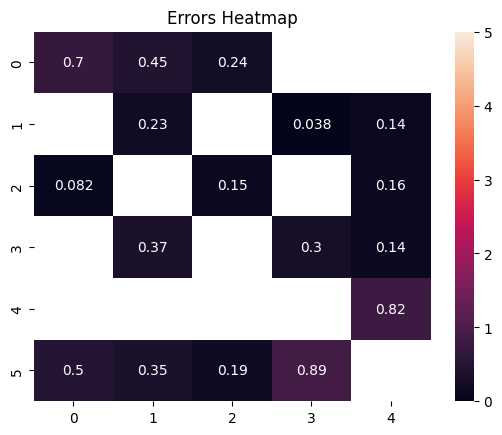

In [6]:
test_NMF_method = HDDA(X=np.array([
                    [2, 3, 2, np.nan, np.nan],
                    [np.nan, 2, np.nan, 4, 3],
                    [3, np.nan, 3, np.nan, 4],
                    [np.nan, 3, np.nan, 4, 3],
                    [np.nan, np.nan, np.nan, np.nan, 2],
                    [1, 4, 3, 4, np.nan]]),
                r=3, precision=5, patience=1
    )
test_NMF_method.init_UV('random')
test_NMF_method.NMF(max_iter=1000, log_step=1, tol=1e-10)
test_NMF_method.show_error_heatmap(max(test_NMF_method.m, test_NMF_method.n))

ClearML Task: created new task id=7f0ea4353d704f20874e617c21cb2f4b
2024-11-27 00:55:53,341 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/520a519c5b09413f9400a52e9dbf3d61/experiments/7f0ea4353d704f20874e617c21cb2f4b/output/log
Seeded everything!
Seeded everything!
Train size: 640135	Validation size: 160033


Training:   1%|█▏                                                                                                               | 1/100 [00:00<00:57,  1.73it/s]

Iteration 1: Training Loss = 3.21362
Validation RMSE: 3.22326


Training:  11%|████████████▎                                                                                                   | 11/100 [00:06<01:01,  1.46it/s]

Iteration 11: Training Loss = 3.13064
Validation RMSE: 3.1578


Training:  21%|███████████████████████▌                                                                                        | 21/100 [00:12<00:44,  1.78it/s]

Iteration 21: Training Loss = 2.97416
Validation RMSE: 3.02788


Training:  31%|██████████████████████████████████▋                                                                             | 31/100 [00:17<00:38,  1.80it/s]

Iteration 31: Training Loss = 2.93171
Validation RMSE: 2.99097


Training:  41%|█████████████████████████████████████████████▉                                                                  | 41/100 [00:22<00:32,  1.84it/s]

Iteration 41: Training Loss = 2.91461
Validation RMSE: 2.97552


Training:  51%|█████████████████████████████████████████████████████████                                                       | 51/100 [00:27<00:26,  1.82it/s]

Iteration 51: Training Loss = 2.9044
Validation RMSE: 2.96591


Training:  61%|████████████████████████████████████████████████████████████████████▎                                           | 61/100 [00:32<00:21,  1.83it/s]

Iteration 61: Training Loss = 2.89826
Validation RMSE: 2.96004


Training:  71%|███████████████████████████████████████████████████████████████████████████████▌                                | 71/100 [00:38<00:16,  1.81it/s]

Iteration 71: Training Loss = 2.89451
Validation RMSE: 2.95634


Training:  81%|██████████████████████████████████████████████████████████████████████████████████████████▋                     | 81/100 [00:44<00:14,  1.32it/s]

Iteration 81: Training Loss = 2.89198
Validation RMSE: 2.95377


Training:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 91/100 [00:50<00:05,  1.69it/s]

Iteration 91: Training Loss = 2.89013
Validation RMSE: 2.95193


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]

Iteration 100: Training Loss = 2.88887
Validation RMSE: 2.95063


1         1.52357
2         1.00000
3         1.00000
4         1.00000
5         1.00000
           ...   
200037    1.00000
200038    1.00000
200039    1.01548
200040    1.00000
200041    1.00000
Length: 200041, dtype: float64

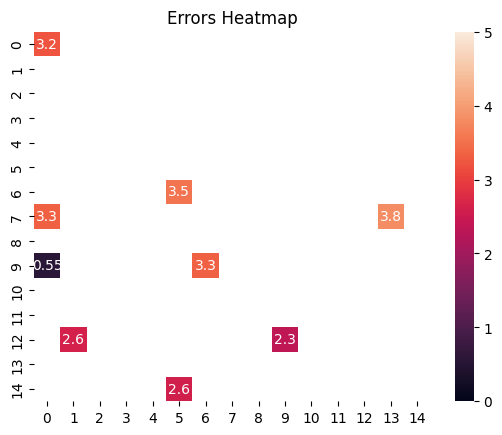

In [7]:
configs = dict(max_iter=100, r=15, predicts_path='./NMF/predicts.csv')

kaggle_NMF = HDDA(X='./inputX.mat', r=configs['r'], task_name='kaggle_NMF', 
                  debug=False, patience=10, precision=5)
kaggle_NMF.init_UV('random')
kaggle_NMF.create_val(0.2)

try:
    kaggle_NMF.NMF(max_iter=configs['max_iter'], log_step=10, tol=1e-4)
except KeyboardInterrupt:
    kaggle_NMF.task.close()

kaggle_NMF.show_error_heatmap(15)

os.makedirs('./NMF/', exist_ok=True)
kaggle_NMF.test(path='./inputEval.mat', predicts_path=configs['predicts_path'])
np.savetxt("./NMF/U.csv", kaggle_NMF.U, delimiter=",")
np.savetxt("./NMF/V.csv", kaggle_NMF.V, delimiter=",")

kaggle_NMF.task.close()
kaggle_NMF.test_predicts

In [8]:
# Warning: we have only 10 submissions per day, use it carefully!
# !kaggle competitions submit -c recommendation-systems -f {predicts_path} -m "Nonnegative Matrix Factorization method with: {configs['r']} latency factors, 9900 iters, {kaggle_NMF.finish_val_loss} rmse on validation"

It give us 1.1098 rmse on test set (on the kaggle): 15 latency factors, 9900 iterations, 1.08976 rmse on validation set with nonnegative matrix factorization method.

As bigger rank we put, as bigger divergence between test and validate scores we have. More appropriate rank ~15

# <a id='toc2_'></a>[A. Block coordinate descent method](#toc0_)

https://dspace.mit.edu/bitstream/handle/1721.1/3164/P-1924-21454764.pdf?sequence=1&isAllowed=y

**Problem for Rank $ r = 1 $**

We are given a sparse matrix $ X \in \mathbb{R}^{m \times n} $, where only some elements $ (i, j) \in \Omega $ are observed. The goal is to approximate $ X $ as the outer product of two vectors:
$$
X \approx uv^\top, \quad u \in \mathbb{R}^m, \, v \in \mathbb{R}^n
$$

**Objective Function**

The approximation error is defined using the observed entries. Let $ W \in \{0, 1\}^{m \times n} $ be a binary mask, where:
$$
W_{ij} = 
\begin{cases}
1, & \text{if } (i, j) \in \Omega, \\
0, & \text{otherwise}.
\end{cases}
$$
The optimization problem is formulated as:
$$
\min_{u, v} \sum_{(i, j) \in \Omega} \left( X_{ij} - u_i v_j \right)^2
$$
or equivalently, using $ W $:
$$
\min_{u, v} \| W \odot (X - uv^\top) \|_F^2
$$
where $ \odot $ denotes the elementwise product and $ \| \cdot \|_F $ is the Frobenius norm.

**Alternating Updates**

This optimization can be solved using a **block coordinate descent (BCD)** approach:
1. **Fix $ u $, update $ v $:**
   Solve for $ v $ while holding $ u $ fixed:
   $$
   v_j = \arg\min_{v_j} \sum_{i \,:\, W_{ij} = 1} \left( X_{ij} - u_i v_j \right)^2
   $$
   This is a least squares problem with the solution:
   $$
   v_j = \frac{\sum_{i \,:\, W_{ij} = 1} u_i X_{ij}}{\sum_{i \,:\, W_{ij} = 1} u_i^2}
   $$
2. **Fix $ v $, update $ u $:**
   Similarly, update each $ u_i $ by solving:
   $$
   u_i = \arg\min_{u_i} \sum_{j \,:\, W_{ij} = 1} \left( X_{ij} - u_i v_j \right)^2
   $$
   The closed-form solution is:
   $$
   u_i = \frac{\sum_{j \,:\, W_{ij} = 1} v_j X_{ij}}{\sum_{j \,:\, W_{ij} = 1} v_j^2}
   $$

---

**Generalization to Rank $ r > 1 $**

When $ r > 1 $, the matrix $ X $ is approximated as the product of two low-rank matrices:
$$
X \approx UV^\top, \quad U \in \mathbb{R}^{m \times r}, \, V \in \mathbb{R}^{n \times r}
$$

**Objective Function**

The generalized objective function becomes:
$$
\min_{U, V} \| W \odot (X - UV^\top) \|_F^2
$$

We also add a regularization term to avoid overfitting:
$$
\min_{U, V} \| W \odot (X - UV^\top) \|_F^2 + \lambda_{\text{reg}} \left( \| U \|_F^2 + \| V \|_F^2 \right)
$$
where $ \lambda_{\text{reg}} $ is a hyperparameter controlling the regularization strength.

**Alternating Updates**

As with the rank-1 case, we use BCD to alternately update $ U $ and $ V $.

1. **Fix $ U $, update $ V $:**
   For each column $ j $ of $ V $, solve:
   $$
   V[j, :] = \arg\min_{v_j} \sum_{i \,:\, W_{ij} = 1} \left( X_{ij} - U[i, :] v_j^\top \right)^2 + \lambda_{\text{reg}} \| v_j \|_2^2
   $$
   Let $ \text{known\_idx} = \{i : W_{ij} = 1\} $. Define:
   $$
   U_{\text{known}} \in \mathbb{R}^{|\text{known\_idx}| \times r}, \quad X_{\text{known}} \in \mathbb{R}^{|\text{known\_idx}|}
   $$
   The update is obtained by solving the normal equations:
   $$
   A = U_{\text{known}}^\top U_{\text{known}} + \lambda_{\text{reg}} I_r, \quad b = U_{\text{known}}^\top X_{\text{known}}
   $$
   $$
   V[j, :] = A^{-1} b
   $$

2. **Fix $ V $, update $ U $:**
   Similarly, for each row $ i $ of $ U $, solve:
   $$
   U[i, :] = \arg\min_{u_i} \sum_{j \,:\, W_{ij} = 1} \left( X_{ij} - u_i V[j, :]^\top \right)^2 + \lambda_{\text{reg}} \| u_i \|_2^2
   $$
   Let $ \text{known\_idx} = \{j : W_{ij} = 1\} $. Define:
   $$
   V_{\text{known}} \in \mathbb{R}^{|\text{known\_idx}| \times r}, \quad X_{\text{known}} \in \mathbb{R}^{|\text{known\_idx}|}
   $$
   Solve:
   $$
   A = V_{\text{known}}^\top V_{\text{known}} + \lambda_{\text{reg}} I_r, \quad b = V_{\text{known}}^\top X_{\text{known}}
   $$
   $$
   U[i, :] = A^{-1} b
   $$

---

**Assumptions and Properties**
1. **Sparse Data Handling:** The updates only involve the observed entries of $ X $, making the algorithm efficient for large, sparse datasets.
2. **Regularization:** The term $ \lambda_{\text{reg}} $ ensures numerical stability (prevents singular matrices) and controls overfitting.
3. **Convergence:** The BCD method iteratively decreases the objective function, converging to a local minimum.

In [7]:
@add_to_class(HDDA)
def BCD(
    self, 
    max_iter: int = 100, 
    tol: float = 1e-4, 
    lambda_reg: float = 0.1, 
    log_step: int = 10
) -> np.ndarray:
    """
    Performs Matrix Factorization (MF) using Block Coordinate Descent (BCD) 
    with Alternating Least Squares (ALS) to minimize the reconstruction error 
    of a given sparse matrix.

    Args:
    -----
    max_iter (int): The maximum number of iterations for the optimization algorithm.
    tol (float): Convergence tolerance. The algorithm stops if the change in training loss 
                 between consecutive iterations is smaller than this value.
    lambda_reg (float): Regularization parameter (L2). Controls overfitting by penalizing 
                        large values in `U` and `V`.
    log_step (int): Frequency of logging progress during training. Metrics are logged every `log_step` iterations.

    Returns:
    --------
    np.ndarray: The predicted matrix `UV^T` after factorization.

    Attributes Modified:
    --------------------
    U (np.ndarray): User-factor matrix (updated during the process).
    V (np.ndarray): Item-factor matrix (updated during the process).
    iterations_completed (int): Number of completed iterations before convergence or reaching `max_iter`.
    finish_val_loss (float, optional): Final validation loss, if a validation set is provided.

    Method Details:
    ---------------
    The method factorizes the input matrix `X` into two low-rank matrices `U` and `V`. It alternates 
    between fixing one matrix and solving for the other using least squares, while considering only 
    the observed entries in `X` (as indicated by the mask `W`).

    Optimization Problem:
        The optimization objective is:
            min_{U, V} || W ⊙ (X - UV^T) ||_F^2 + lambda_reg * (||U||_F^2 + ||V||_F^2)
        where:
            - `W` is a binary mask indicating observed entries in `X`.
            - `⊙` denotes the element-wise (Hadamard) product.
            - `||·||_F` denotes the Frobenius norm.

    Algorithm Steps:
    ----------------
    1. Initialize `U` and `V` randomly or with a predefined strategy.
    2. Iterate for a maximum of `max_iter`:
       a. Fix `U` and update each column of `V`:
          V[:, j] = (UᵀU + λI)⁻¹(UᵀX[:, j])
       b. Fix `V` and update each row of `U`:
          U[i, :] = (VᵀV + λI)⁻¹(VᵀX[i, :])
    3. Compute training and validation losses.
    4. Stop when the relative change in loss is smaller than `tol` or after `max_iter` iterations.

    Notes:
    ------
    - Regularization is applied to ensure stability and prevent overfitting.
    - This method is efficient for sparse matrices as it operates only on observed entries in `X`.
    - The binary mask `W` must match the shape of `X` and indicate which entries are observed.

    Example:
    --------
    >>> model = HDDA(X, W, r=10)
    >>> predictions = model.BCD(max_iter=50, tol=1e-5, lambda_reg=0.05)
    >>> print(predictions)
    """
    if not self.debug:
        self.task.connect(dict(max_iter=max_iter, lambda_reg=lambda_reg, tol=tol))
        
    train_losses: list[float] = []
    val_losses: list[float] = []
    prev_loss: float = np.inf

    for idx in tqdm(range(max_iter), desc="Block coordinate descent method: min f(U,V)"):
        
        for j in tqdm(range(self.n), desc='Fix U and update V', disable=self.debug):
            # Extract known entries for column j
            known_idx = self.W[:, j].nonzero()[0]  # Observed entries in column j
            U_known = self.U[known_idx, :]  # Corresponding rows of U
            X_known = self.X[known_idx, j]  # Known values in column j of X

            # Solve for V[:, j] using the normal equation
            A: np.ndarray = U_known.T @ U_known + lambda_reg * np.eye(self.r)
            b: np.ndarray = U_known.T @ X_known
            self.V[:, j] = np.linalg.solve(A, b).T

        for i in tqdm(range(self.m), desc='Fix new V and update U', disable=self.debug):
            # Extract known entries for row i
            known_idx = self.W[i, :].nonzero()[0]  # Observed entries in row i
            V_known = self.V[:, known_idx]  # Corresponding columns of V
            X_known = self.X[i, known_idx]  # Known values in row i of X

            # Solve for U[i, :] using the normal equation
            A: np.ndarray = V_known @ V_known.T + lambda_reg * np.eye(self.r)
            b: np.ndarray = V_known @ X_known.T
            self.U[i, :] = np.linalg.solve(A, b).T

        converged, train_loss, val_loss, prev_loss = self.log_metrics(
            self.U, self.V, idx, log_step, max_iter, prev_loss, tol)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if converged: 
            self.iterations_completed: int = idx
            break
    else:
        self.iterations_completed: int = max_iter

    if hasattr(self, 'val'):
        if not self.debug:
            self.logger.report_single_value('final_val_loss', val_loss)
        self.finish_val_loss: float = val_loss

    return self.predict(self.U, self.V)


Seeded everything!


Block coordinate descent method: min f(U,V): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 734.58it/s]

Iteration 1: Training Loss = 0.20609
Iteration 2: Training Loss = 0.06884
Iteration 3: Training Loss = 0.05377
Iteration 4: Training Loss = 0.04564
Iteration 5: Training Loss = 0.04022
Iteration 6: Training Loss = 0.03679
Iteration 7: Training Loss = 0.03465
Iteration 8: Training Loss = 0.0333
Iteration 9: Training Loss = 0.0324
Iteration 10: Training Loss = 0.03176


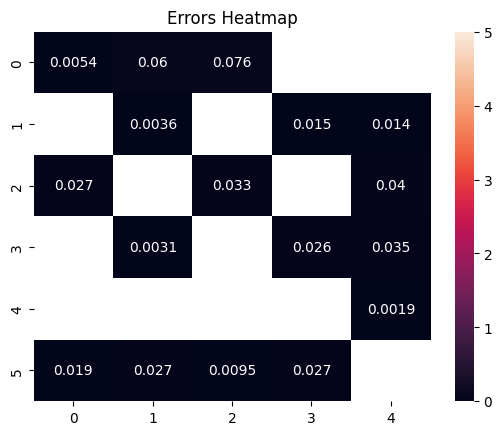

In [8]:
test_BCD_method = HDDA(X=np.array([
                    [2, 3, 2, np.nan, np.nan],
                    [np.nan, 2, np.nan, 4, 3],
                    [3, np.nan, 3, np.nan, 4],
                    [np.nan, 3, np.nan, 4, 3],
                    [np.nan, np.nan, np.nan, np.nan, 2],
                    [1, 4, 3, 4, np.nan]]),
                r=2, task_name='test_BCD', precision=5
    )
test_BCD_method.init_UV('random')
test_BCD_method.BCD(max_iter=10, log_step=1, lambda_reg=0.01, tol=1e-4)
test_BCD_method.show_error_heatmap(max(test_BCD_method.m, test_BCD_method.n))

### <a id='toc2_1_1_'></a>[Hyperparameters tuning](#toc0_)

In [33]:
# Define the objective function for Optuna optimization
def objective(trial: optuna.Trial):
    # Suggest the rank of the matrix factorization (dimensionality of latent factors)
    rank = trial.suggest_int("rank", 2, 20)  # The rank can vary from 2 to 20 (integer values)
    
    # Suggest the initialization method for matrices U and V
    init_UV = trial.suggest_categorical("init_UV", ["random", "eye", "zeros", "SVD"]) 
    # Options for initialization: "random", "eye" (identity matrix), "zeros", or "SVD" (Singular Value Decomposition)

    # Suggest a regularization parameter for controlling overfitting (lambda regularization)
    lambda_reg = trial.suggest_float("lambda_reg", 1e-10, 1, log=True) 
    # Regularization parameter suggested in the range 1e-10 to 1, using a log scale
    
    # Initialize the HDDA class with the dataset and hyperparameters
    kaggle_BCD = HDDA(X='./inputX.mat',   # Input data file
                      r=rank,           # Rank of matrix factorization
                      precision=5,      # Precision level for calculations
                      patience=2,       # Patience for early stopping criterion
                      debug=True,       # Enable debug logging for internal processes
                      seed=42)          # Random seed to ensure reproducibility
    
    # Split the data into training and validation sets (80% train, 20% validation)
    kaggle_BCD.create_val(0.2)
    
    # Initialize the factorization matrices (U, V) using the chosen initialization method
    kaggle_BCD.init_UV(init_UV)
    
    # Run the Block Coordinate Descent (BCD) algorithm for matrix factorization
    kaggle_BCD.BCD(max_iter=100,         # Maximum number of iterations for BCD
                   log_step=5,           # Log progress every 5 steps
                   tol=1e-4,            # Convergence tolerance for stopping criterion
                   lambda_reg=lambda_reg)  # Regularization parameter

    # Return the final validation loss to Optuna, this will be minimized during the optimization
    return kaggle_BCD.finish_val_loss


# Create an Optuna study for hyperparameter optimization
study = optuna.create_study(storage="sqlite:///db.sqlite3",  # Save the study results in an SQLite database
                            study_name="hdda-project-recommendation_systems-BCD",  # Name of the study
                            direction="minimize",  # Goal is to minimize the objective function
                            load_if_exists=True)  # Load the study if it already exists

# Optimize the objective function over 1000 trials (random search) and show the progress bar
study.optimize(objective, n_trials=10, show_progress_bar=True)

# Retrieve the best trial (with the lowest validation loss)
best_trial_BCD = study.best_trial


[I 2024-11-27 13:58:40,513] Using an existing study with name 'hdda-project-recommendation_systems-BCD' instead of creating a new one.


  0%|          | 0/10 [00:00<?, ?it/s]

Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 0.79743
Validation RMSE: 0.88424


Iteration 6: Training Loss = 0.79692
Validation RMSE: 0.88737


Iteration 11: Training Loss = 0.79687
Validation RMSE: 0.88778


Iteration 16: Training Loss = 0.79686
Validation RMSE: 0.88792


Block coordinate descent method: min f(U,V):  20%|▏| 20/100 [00:15<01:01,  1.31i

Iteration 21: Training Loss = 0.79685
Validation RMSE: 0.88798
Converged at iteration 21
Training Loss = 0.79685
Validation RMSE: 0.88798


[I 2024-11-27 13:58:58,899] Trial 2979 finished with value: 0.8879777119532257 and parameters: {'rank': 5, 'init_UV': 'SVD', 'lambda_reg': 0.16697485351060806}. Best is trial 1500 with value: 0.8760840080179032.
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 0.78265
Validation RMSE: 0.88434


Iteration 6: Training Loss = 0.7821
Validation RMSE: 0.88377


Iteration 11: Training Loss = 0.78207
Validation RMSE: 0.88384


Iteration 16: Training Loss = 0.78206
Validation RMSE: 0.88386


Iteration 21: Training Loss = 0.78206
Validation RMSE: 0.88386


Block coordinate descent method: min f(U,V):  25%|▎| 25/100 [00:18<00:56,  1.33i

Iteration 26: Training Loss = 0.78206
Validation RMSE: 0.88385
Converged at iteration 26
Training Loss = 0.78206
Validation RMSE: 0.88385


[I 2024-11-27 13:59:19,121] Trial 2980 finished with value: 0.8838533028564964 and parameters: {'rank': 6, 'init_UV': 'SVD', 'lambda_reg': 0.48250394106357636}. Best is trial 1500 with value: 0.8760840080179032.
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 0.79889
Validation RMSE: 0.87893


Iteration 6: Training Loss = 0.79841
Validation RMSE: 0.87873


Iteration 11: Training Loss = 0.79838
Validation RMSE: 0.87874


Iteration 16: Training Loss = 0.79837
Validation RMSE: 0.87875


Iteration 21: Training Loss = 0.79836
Validation RMSE: 0.87875


Block coordinate descent method: min f(U,V):  25%|▎| 25/100 [00:18<00:56,  1.32i

Iteration 26: Training Loss = 0.79836
Validation RMSE: 0.87876
Converged at iteration 26
Training Loss = 0.79836
Validation RMSE: 0.87876


[I 2024-11-27 13:59:39,435] Trial 2981 finished with value: 0.8787603213523233 and parameters: {'rank': 5, 'init_UV': 'SVD', 'lambda_reg': 0.6676691318445804}. Best is trial 1500 with value: 0.8760840080179032.
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 0.81653
Validation RMSE: 0.8816


Iteration 6: Training Loss = 0.81506
Validation RMSE: 0.88132


Iteration 11: Training Loss = 0.81492
Validation RMSE: 0.88123


Iteration 16: Training Loss = 0.81488
Validation RMSE: 0.88127


Iteration 21: Training Loss = 0.81487
Validation RMSE: 0.88127


Block coordinate descent method: min f(U,V):  25%|▎| 25/100 [00:19<00:58,  1.29i

Iteration 26: Training Loss = 0.81486
Validation RMSE: 0.88128
Converged at iteration 26
Training Loss = 0.81486
Validation RMSE: 0.88128


[I 2024-11-27 14:00:00,229] Trial 2982 finished with value: 0.8812787260604601 and parameters: {'rank': 4, 'init_UV': 'SVD', 'lambda_reg': 0.3553739268418564}. Best is trial 1500 with value: 0.8760840080179032.
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 0.79893
Validation RMSE: 0.87913


Iteration 6: Training Loss = 0.79837
Validation RMSE: 0.8788


Iteration 11: Training Loss = 0.79834
Validation RMSE: 0.87884


Iteration 16: Training Loss = 0.79833
Validation RMSE: 0.87887


Iteration 21: Training Loss = 0.79833
Validation RMSE: 0.87888


Block coordinate descent method: min f(U,V):  25%|▎| 25/100 [00:19<00:58,  1.29i

Iteration 26: Training Loss = 0.79832
Validation RMSE: 0.8789
Converged at iteration 26
Training Loss = 0.79832
Validation RMSE: 0.8789


[I 2024-11-27 14:00:20,966] Trial 2983 finished with value: 0.8789021292634175 and parameters: {'rank': 5, 'init_UV': 'SVD', 'lambda_reg': 0.6566668123885087}. Best is trial 1500 with value: 0.8760840080179032.
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 0.79832
Validation RMSE: 0.87891


Iteration 6: Training Loss = 0.79832
Validation RMSE: 0.87892


Iteration 11: Training Loss = 0.79832
Validation RMSE: 0.87892


Iteration 16: Training Loss = 0.79832
Validation RMSE: 0.87893


Block coordinate descent method: min f(U,V):  20%|▏| 20/100 [00:15<01:00,  1.33i

Iteration 21: Training Loss = 0.79832
Validation RMSE: 0.87893
Converged at iteration 21
Training Loss = 0.79832
Validation RMSE: 0.87893


[I 2024-11-27 14:00:37,355] Trial 2984 finished with value: 0.8789295335218386 and parameters: {'rank': 5, 'init_UV': 'SVD', 'lambda_reg': 0.6568160127410521}. Best is trial 1500 with value: 0.8760840080179032.
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 0.79782
Validation RMSE: 0.88096


Iteration 6: Training Loss = 0.7977
Validation RMSE: 0.88144


Iteration 11: Training Loss = 0.79769
Validation RMSE: 0.88149


Iteration 16: Training Loss = 0.79769
Validation RMSE: 0.88149


Block coordinate descent method: min f(U,V):  20%|▏| 20/100 [00:15<01:02,  1.27i

Iteration 21: Training Loss = 0.79768
Validation RMSE: 0.88149
Converged at iteration 21
Training Loss = 0.79768
Validation RMSE: 0.88149


[I 2024-11-27 14:00:54,465] Trial 2985 finished with value: 0.8814929658944597 and parameters: {'rank': 5, 'init_UV': 'SVD', 'lambda_reg': 0.4494628485839535}. Best is trial 1500 with value: 0.8760840080179032.
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 0.78202
Validation RMSE: 0.88736


Iteration 6: Training Loss = 0.78121
Validation RMSE: 0.88951


Iteration 11: Training Loss = 0.78116
Validation RMSE: 0.88998


Iteration 16: Training Loss = 0.78114
Validation RMSE: 0.89016


Block coordinate descent method: min f(U,V):  20%|▏| 20/100 [00:16<01:05,  1.22i

Iteration 21: Training Loss = 0.78113
Validation RMSE: 0.89024
Converged at iteration 21
Training Loss = 0.78113
Validation RMSE: 0.89024


[I 2024-11-27 14:01:12,263] Trial 2986 finished with value: 0.8902399807983856 and parameters: {'rank': 6, 'init_UV': 'SVD', 'lambda_reg': 0.24312297019503684}. Best is trial 1500 with value: 0.8760840080179032.
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 0.81672
Validation RMSE: 0.87928


Iteration 6: Training Loss = 0.81559
Validation RMSE: 0.87861


Iteration 11: Training Loss = 0.81554
Validation RMSE: 0.87857


Iteration 16: Training Loss = 0.81553
Validation RMSE: 0.87855


Iteration 21: Training Loss = 0.81553
Validation RMSE: 0.87854


Block coordinate descent method: min f(U,V):  25%|▎| 25/100 [00:18<00:56,  1.33i

Iteration 26: Training Loss = 0.81552
Validation RMSE: 0.87854
Converged at iteration 26
Training Loss = 0.81552
Validation RMSE: 0.87854


[I 2024-11-27 14:01:32,597] Trial 2987 finished with value: 0.8785364796895585 and parameters: {'rank': 4, 'init_UV': 'SVD', 'lambda_reg': 0.6557753445868364}. Best is trial 1500 with value: 0.8760840080179032.
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 0.79854
Validation RMSE: 0.88115


Iteration 6: Training Loss = 0.7977
Validation RMSE: 0.88133


Iteration 11: Training Loss = 0.79766
Validation RMSE: 0.88142


Iteration 16: Training Loss = 0.79765
Validation RMSE: 0.88148


Block coordinate descent method: min f(U,V):  20%|▏| 20/100 [00:15<01:01,  1.29i

Iteration 21: Training Loss = 0.79765
Validation RMSE: 0.88152
Converged at iteration 21
Training Loss = 0.79765
Validation RMSE: 0.88152


[I 2024-11-27 14:01:49,441] Trial 2988 finished with value: 0.8815180583311453 and parameters: {'rank': 5, 'init_UV': 'SVD', 'lambda_reg': 0.4360257294165083}. Best is trial 1500 with value: 0.8760840080179032.


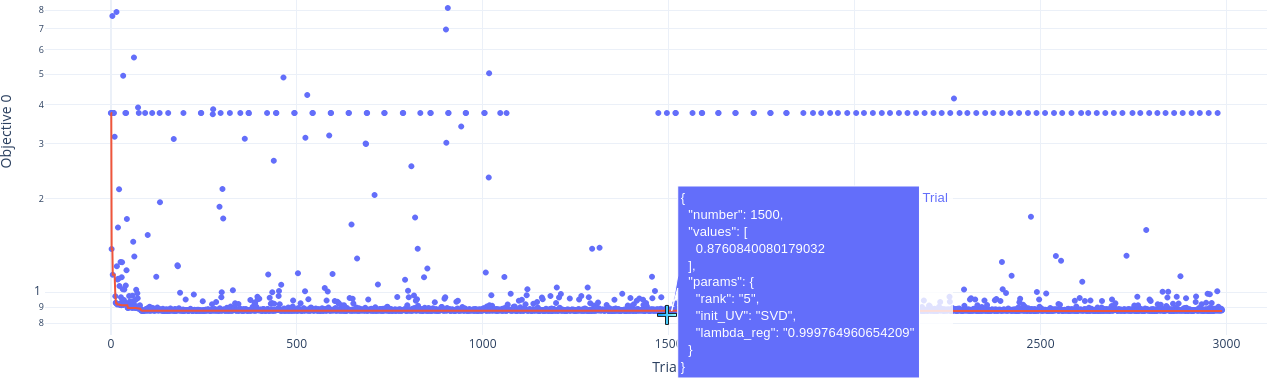

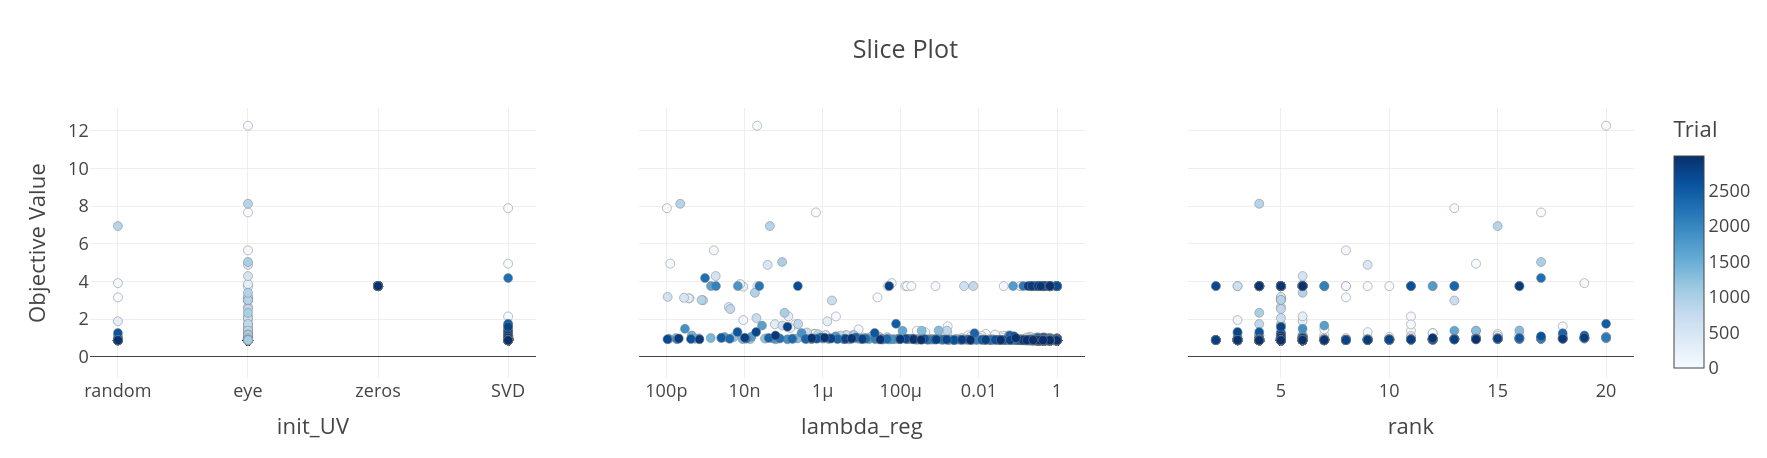

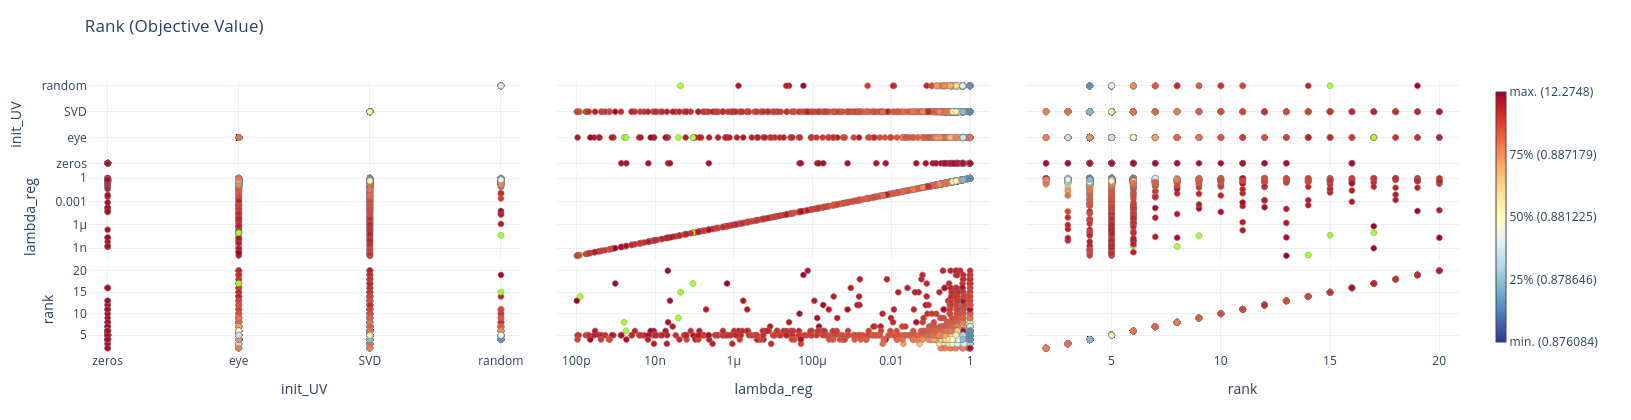

Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Fix new V and update U: 100%|████████████| 6040/6040 [00:00<00:00, 27830.98it/s]
Block coordinate descent method: min f(U,V):   0%| | 1/500 [00:00<07:38,  1.09it

Iteration 1: Training Loss = 0.79912
Validation RMSE: 0.87663


Fix new V and update U: 100%|████████████| 6040/6040 [00:00<00:00, 28149.38it/s]
Block coordinate descent method: min f(U,V):  10%| | 51/500 [00:38<05:54,  1.27i

Iteration 51: Training Loss = 0.79938
Validation RMSE: 0.87615


Fix new V and update U: 100%|████████████| 6040/6040 [00:00<00:00, 28168.88it/s]
Block coordinate descent method: min f(U,V):  20%|▏| 101/500 [01:13<05:04,  1.31

Iteration 101: Training Loss = 0.79938
Validation RMSE: 0.87615


Fix new V and update U: 100%|████████████| 6040/6040 [00:00<00:00, 28139.12it/s]
Block coordinate descent method: min f(U,V):  30%|▎| 151/500 [01:49<04:29,  1.30

Iteration 151: Training Loss = 0.79938
Validation RMSE: 0.87614


Fix new V and update U: 100%|████████████| 6040/6040 [00:00<00:00, 28147.85it/s]
Block coordinate descent method: min f(U,V):  40%|▍| 200/500 [02:25<03:38,  1.37

Iteration 201: Training Loss = 0.79938
Validation RMSE: 0.87614
Converged at iteration 201
Training Loss = 0.79938
Validation RMSE: 0.87614


1         4.25794
2         4.14350
3         4.34592
4         4.65887
5         4.33579
           ...   
200037    4.12641
200038    3.59448
200039    3.42872
200040    4.41076
200041    3.47204
Length: 200041, dtype: float64

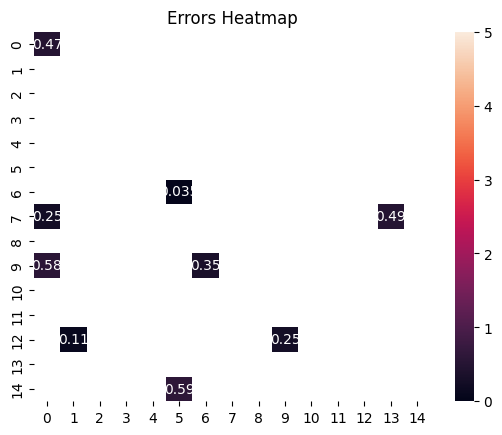

In [34]:
best_trial_BCD = study.best_trial
configs = dict(max_iter=500, r=best_trial_BCD.params['rank'], 
               tol=1e-4, lambda_reg=best_trial_BCD.params['lambda_reg'],  
               predicts_path='./BCD/predicts.csv', 
               init_UV=best_trial_BCD.params['init_UV'], precision=5, seed=42)

kaggle_BCD = HDDA(X='./inputX.mat', r=configs['r'], patience=1,
                  task_name='kaggle_BCD', precision=configs['precision'], 
                  debug=False, seed=configs['seed'])
kaggle_BCD.create_val(0.2)

kaggle_BCD.init_UV(configs['init_UV'])
kaggle_BCD.BCD(max_iter=configs['max_iter'], tol=configs['tol'], 
               lambda_reg=configs['lambda_reg'], log_step=configs['max_iter']/10)

kaggle_BCD.show_error_heatmap(15)

os.makedirs('./BCD/', exist_ok=True)
kaggle_BCD.test(path='./inputEval.mat', predicts_path=configs['predicts_path'])
np.savetxt("./BCD/U.csv", kaggle_BCD.U, delimiter=",")
np.savetxt("./BCD/V.csv", kaggle_BCD.V, delimiter=",")

kaggle_BCD.task.close()
kaggle_BCD.test_predicts

In [35]:
# Warning: we have only 10 submissions per day, use it carefully!
message = f'Block coordinate descent method ALS with: {kaggle_BCD.iterations_completed} iterations overall, {kaggle_BCD.finish_val_loss} rmse on validation. Configs: {configs}'
kaggle_BCD.submit(configs['predicts_path'], message=message)
message

100%|██████████| 2.72M/2.72M [00:01<00:00, 1.57MB/s]


Successfully submitted to Recommendation System Project

"Block coordinate descent method ALS with: 200 iterations overall, 0.8761400549304317 rmse on validation. Configs: {'max_iter': 500, 'r': 5, 'tol': 0.0001, 'lambda_reg': 0.999764960654209, 'predicts_path': './BCD/predicts.csv', 'init_UV': 'SVD', 'precision': 5, 'seed': 42}"

Here we have 0.8734 rmse on the test set (with 0.87614 rmse on validation set)

# <a id='toc3_'></a>[B. Gradient Descent](#toc0_)

Let the objective function to be minimized be represented as:

$$
L(U, V) = \frac{1}{2} \| X - UV^T \|^2_F + \lambda \left( \| U \|^2_F + \| V \|^2_F \right)
$$

where:
- $ X \in \mathbb{R}^{m \times n} $ is the observed matrix,
- $ U \in \mathbb{R}^{m \times k} $ and $ V \in \mathbb{R}^{n \times k} $ are the factor matrices to be optimized,
- $ \| \cdot \|_F $ denotes the Frobenius norm,
- $ \lambda $ is a regularization parameter.

The goal is to find the matrices $ U $ and $ V $ that minimize the loss function $ L(U, V) $.

**Block Coordinate Descent Method**

The BCGD method optimizes the factor matrices $ U $ and $ V $ by alternately updating each block while keeping the other fixed.

1. **Update $ U $**:  
   The gradient of the loss function with respect to $ U $ is given by:

   $$
   \nabla_U L(U, V) = -2 (X - UV^T) V + 2 \lambda U
   $$

   The update for $ U $ is performed by applying gradient descent:

   $$
   U \leftarrow U - \alpha_U \nabla_U L(U, V)
   $$

   where $ \alpha_U $ is the learning rate (step size).

2. **Update $ V $**:  
   Similarly, the gradient of the loss function with respect to $ V $ is:

   $$
   \nabla_V L(U, V) = -2 (X - UV^T)^T U + 2 \lambda V
   $$

   The update for $ V $ is performed by:

   $$
   V \leftarrow V - \alpha_V \nabla_V L(U, V)
   $$

   where $ \alpha_V $ is the learning rate for $ V $.

**Adaptive Step Size Update**

The step sizes $ \alpha_U $ and $ \alpha_V $ are dynamically adjusted based on the observed decrease in the loss. If the loss does not decrease after a certain number of steps, the learning rate is decreased by a factor of $ \gamma $ (the decay factor).

**Convergence Criteria**

The optimization continues iterating until one of the following conditions is met:
1. **Convergence**: If the change in the loss function between iterations is smaller than a threshold $ \epsilon $.
2. **Maximum Iterations**: The maximum number of iterations $ T $ is reached.
3. **NaN or Divergence**: If the loss becomes NaN or grows excessively.

**Final Prediction**

Once the optimization completes, the predicted matrix $ \hat{X} $ is given by:

$$
\hat{X} = UV^T
$$

In [9]:
@add_to_class(HDDA)
def BCGD(
    self,
    lr: Optional[float] = None,
    sigma: float = 1.0,
    gamma: float = 1.0,
    max_iter: int = 100,
    log_step: int = 2,
    tol: float = 1e-4,
    patience: int = 10,
    lambda_reg: float = 0.1
) -> np.ndarray:
    """
    Block Coordinate Gradient Descent (BCGD) Method.
    
    This method performs optimization using block coordinate gradient descent with optional adaptive
    step size adjustment and regularization. It alternately updates two parameter matrices, `U` and `V`, 
    by minimizing the loss function through gradient-based updates.

    Parameters:
    ----------
    - **lr**: Optional[float], default=None
        Initial learning rate for gradient descent. If not provided or set to `None`, the step size 
        will be dynamically adjusted.
        
    - **sigma**: float, default=1.0
        Scaling factor for the step size in adaptive step size adjustment.
        
    - **gamma**: float, default=1.0
        Step size decay factor when the loss does not decrease.
        
    - **max_iter**: int, default=100
        Maximum number of iterations for optimization.
        
    - **log_step**: int, default=2
        Frequency of logging and reporting metrics (in iterations).
        
    - **tol**: float, default=1e-4
        Convergence tolerance for stopping the optimization based on training loss.
        
    - **patience**: int, default=10
        Maximum number of step size reductions before stopping the update of a block.
        
    - **lambda_reg**: float, default=0.1
        Regularization parameter for $ L_2 $-norm penalization of parameters `U` and `V`.

    Returns:
    --------
    - **predictions**: np.ndarray
        Predicted matrix after training with the optimized factors `U` and `V`.

    Method Description:
    --------------------
    1. **Initialization**:
        - Connects task parameters if `self.debug` is False.
        - Initializes training and validation loss storage, as well as previous loss for convergence checking.

    2. **Block Update Logic**:
        - A helper function `update_block` is defined to update either `U` or `V`:
            - Computes the gradient of the block based on the current loss function.
            - Dynamically adjusts the step size (`alpha`) if the initial step size does not decrease the loss.
            - Uses a `patience` parameter to reduce the step size repeatedly if necessary.
            - Returns the updated block, the effective step size, and the block-specific loss.

    3. **Iterative Optimization**:
        - Alternately updates `U` and `V` using `update_block`:
            - Updates `U` based on fixed `V` and vice versa.
            - Computes the gradient and applies regularization.
        - Reports step size and loss values for each block at each iteration.
        - Checks for convergence based on the specified `tol` and stops early if the loss does not improve.

    4. **Logging and Output**:
        - Logs training and validation metrics at regular intervals.
        - If validation data is provided, reports the final validation loss.
        - Returns the predictions based on the optimized factors `U` and `V`.

    Usage Example:
    --------------
    ```python
    model = HDDA(...)
    predictions = model.BCGD(lr=0.01, max_iter=200, lambda_reg=0.05, tol=1e-5)
    ```
    """
    
    if not self.debug:
        self.task.connect(dict(learning_rate=lr, max_iter=max_iter, gamma=gamma, sigma=sigma,
                            log_step=log_step, tol=tol, latency_factors=self.r, 
                            lambda_reg=lambda_reg, UV_init_strategy=self.UV_strategy))

    train_losses = []
    val_losses = []
    prev_loss = np.inf
    
    def update_block(B: np.ndarray, fixed_B: np.ndarray, 
                     WR_f: callable, grad_f: callable, lr: Optional[float]
                    ) -> tuple[np.ndarray, float, float]:
        """
        Helper function to update a single block (`U` or `V`) in the BCGD process.
        
        Parameters:
        ----------
        - **B**: np.ndarray
            The matrix to be updated (`U` or `V`).
        
        - **fixed_B**: np.ndarray
            The other matrix (`V` or `U`) which remains fixed during the update of `B`.
        
        - **WR_f**: callable
            A function that computes the weighted residual matrix for the current block and the fixed block.
        
        - **grad_f**: callable
            A function that computes the gradient of the loss function with respect to the current block.
        
        - **lr**: Optional[float]
            The learning rate. If `None`, the step size is dynamically adjusted.

        Returns:
        -------
        - **updated_B**: np.ndarray
            The updated matrix for the current block.
        
        - **effective_lr**: float
            The effective step size used in the update.
        
        - **loss**: float
            The loss value after the update.
        """
        WR = WR_f(B, fixed_B)
        grad_B = grad_f(WR, B, fixed_B)
        if lr is None or not lr:
            alpha = 2 * np.linalg.norm(B) / np.linalg.norm(grad_B)
        else:
            alpha = lr

        error_0 = HDDA.rmse(WR)        
        updated_B = B - alpha * grad_B
        error_1 = HDDA.rmse(WR_f(updated_B, fixed_B))
        
        for _ in range(patience):
            if error_0 > error_1:
                break
            updated_B = B - alpha * grad_B
            error_1 = HDDA.rmse(WR_f(updated_B, fixed_B))
            if np.isnan(error_1) or error_1 > 1e3:
                break
            alpha /= gamma
            
        return updated_B, alpha * sigma, error_1
    
    lr_U, lr_V = lr, lr
    for idx in tqdm(range(max_iter), desc='Training'):
        self.U, lr_U, loss_u = update_block(self.U, self.V, lambda U, V: self.calc_errors_matrix(U, V), 
                                            grad_f=lambda WR, U, V: -2 * WR @ V.T + 2*lambda_reg * U, 
                                            lr=lr_U)
        
        self.V, lr_V, loss_v = update_block(self.V, self.U, lambda V, U: self.calc_errors_matrix(U, V), 
                                            grad_f=lambda WR, V, U: -(2 * WR.T @ U + 2*lambda_reg * V.T).T, 
                                            lr=lr_V)
        
        if not self.debug:
            self.logger.report_scalar('step_size', 'train_U', lr_U, idx)
            self.logger.report_scalar('loss', 'train_U', loss_u, idx)
            self.logger.report_scalar('step_size', 'train_V', lr_V, idx)
            self.logger.report_scalar('loss', 'train_V', loss_v, idx)
        
        converged, train_loss, val_loss, prev_loss = self.log_metrics(self.U, self.V, idx, log_step, 
                                                                      max_iter, prev_loss, tol)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if converged or np.isnan(train_loss) or train_loss > 1e3: break
    else:
        self.iterations_completed = idx

    if hasattr(self, 'val'):
        if not self.debug:
            self.logger.report_single_value('final_val_loss', val_loss)
        self.finish_val_loss = val_loss

    return self.predict(self.U, self.V)


Seeded everything!


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3712.99it/s]

Iteration 1: Training Loss = 6.57
Iteration 11: Training Loss = 0.66
Iteration 21: Training Loss = 0.49
Iteration 31: Training Loss = 0.34
Iteration 41: Training Loss = 0.22
Iteration 51: Training Loss = 0.14
Iteration 61: Training Loss = 0.09
Iteration 71: Training Loss = 0.06
Iteration 81: Training Loss = 0.03
Iteration 91: Training Loss = 0.02
Iteration 100: Training Loss = 0.01


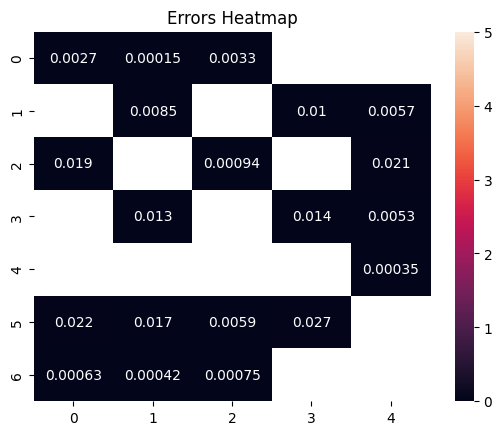

In [10]:
test_BCGD_method = HDDA(X=np.array([
                    [2, 3, 2, np.nan, np.nan],
                    [np.nan, 2, np.nan, 4, 3],
                    [3, np.nan, 3, np.nan, 4],
                    [np.nan, 3, np.nan, 4, 3],
                    [np.nan, np.nan, np.nan, np.nan, 2],
                    [1, 4, 3, 4, np.nan],
                    [5, 3, 2, np.nan, np.nan]]),
                r=4, debug=True
    )
test_BCGD_method.init_UV('random')
test_BCGD_method.BCGD(lr=0.01, max_iter=100, log_step=10, tol=1e-4, 
                      lambda_reg=0.1)
test_BCGD_method.show_error_heatmap(7)

### <a id='toc3_1_1_'></a>[Hyperparameters tuning](#toc0_)

In [39]:
def objective(trial: optuna.Trial):
    # Suggest a rank (number of latent factors) for matrix factorization in the range [3, 20].
    rank = trial.suggest_int("rank", 3, 20)
    
    # Suggest the initialization method for U and V matrices. The options are:
    # "random" - random initialization,
    # "eye" - identity matrix initialization,
    # "zeros" - zero matrix initialization,
    # "SVD" - initialization based on singular value decomposition.
    init_UV = trial.suggest_categorical("init_UV", ["random", "eye", "zeros", "SVD"])
    
    # Suggest a regularization parameter (lambda_reg) in the range [1e-05, 1] with a logarithmic scale.
    lambda_reg = trial.suggest_float("lambda_reg", 1e-05, 1, log=True)
    
    # Suggest a learning rate (lr) in the range [1e-10, 1] with a logarithmic scale.
    lr = trial.suggest_float("lr", 1e-10, 1, log=True)
    
    # Suggest a noise parameter (sigma) in the range [1e-5, 2] with a logarithmic scale.
    sigma = trial.suggest_float("sigma", 1e-5, 2, log=True)
    
    # Suggest the number of iterations for the internal optimization loop (internal_patience).
    internal_patience = trial.suggest_int("internal_patience", 1, 10)
    
    # Suggest a parameter gamma (often related to a decay or regularization in some algorithms).
    gamma = trial.suggest_float("gamma", 1e-10, 2, log=True)

    # Initialize an instance of the HDDA class with the given parameters.
    kaggle_BCGD = HDDA(X='./inputX.mat', r=rank, 
                       precision=5, patience=3,
                       debug=True, seed=42)
    
    # Create validation data with a fraction (20%) from the dataset.
    kaggle_BCGD.create_val(0.2)
    
    # Initialize the UV matrices using the chosen initialization method.
    kaggle_BCGD.init_UV(init_UV)

    # Train the model using the BCGD method with the specified parameters:
    kaggle_BCGD.BCGD(max_iter=20, tol=1e-4, patience=internal_patience, log_step=1,
                     lr=lr, sigma=sigma, gamma=gamma, lambda_reg=lambda_reg)
    
    # Return the final validation loss after training.
    return kaggle_BCGD.finish_val_loss


study = optuna.create_study(storage="sqlite:///db.sqlite3",
                            study_name="hdda-project-recommendation_systems-BCGD",
                            direction="minimize", 
                            load_if_exists=True)

# Optimize the objective function over 10 trials, displaying progress with a progress bar.
study.optimize(objective, n_trials=10, show_progress_bar=True)
best_trial_BCGD = study.best_trial


[I 2024-11-27 14:23:39,976] Using an existing study with name 'hdda-project-recommendation_systems-BCGD' instead of creating a new one.


  0%|          | 0/10 [00:00<?, ?it/s]

Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 0.78911
Validation RMSE: 0.88243


Iteration 2: Training Loss = 0.78911
Validation RMSE: 0.88243


Iteration 3: Training Loss = 0.78911
Validation RMSE: 0.88243


Iteration 4: Training Loss = 0.78911
Validation RMSE: 0.88243


Iteration 5: Training Loss = 0.78911
Validation RMSE: 0.88243


Training:  25%|███████████████████████████████                                                                                             | 5/20 [00:13<00:40,  2.69s/it]

Iteration 6: Training Loss = 0.78911
Validation RMSE: 0.88243
Converged at iteration 6
Training Loss = 0.78911
Validation RMSE: 0.88243


[I 2024-11-27 14:23:56,381] Trial 117 finished with value: 0.8824319714518106 and parameters: {'rank': 15, 'init_UV': 'SVD', 'lambda_reg': 0.009667332966990813, 'lr': 7.959218628107902e-07, 'sigma': 0.0001012276616101173, 'internal_patience': 9, 'gamma': 4.791808112137873e-07}. Best is trial 112 with value: 0.8761341216110965.
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 0.79938
Validation RMSE: 0.87614


Iteration 2: Training Loss = 0.79938
Validation RMSE: 0.87614


Iteration 3: Training Loss = 0.79938
Validation RMSE: 0.87614


Iteration 4: Training Loss = 0.79934
Validation RMSE: 0.87619


Iteration 5: Training Loss = 0.79934
Validation RMSE: 0.87619


Training:  25%|███████████████████████████████                                                                                             | 5/20 [00:12<00:38,  2.56s/it]

Iteration 6: Training Loss = 0.79934
Validation RMSE: 0.87619
Converged at iteration 6
Training Loss = 0.79934
Validation RMSE: 0.87619


[I 2024-11-27 14:24:10,567] Trial 118 finished with value: 0.8761904603936577 and parameters: {'rank': 5, 'init_UV': 'SVD', 'lambda_reg': 0.0015012705609382712, 'lr': 1.2948701127019378e-07, 'sigma': 2.7417710253466204e-05, 'internal_patience': 8, 'gamma': 1.877148509452592e-09}. Best is trial 112 with value: 0.8761341216110965.
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 0.79937
Validation RMSE: 0.87614


Iteration 2: Training Loss = 0.79937
Validation RMSE: 0.87614


Iteration 3: Training Loss = 0.79937
Validation RMSE: 0.87614


Iteration 4: Training Loss = 0.79937
Validation RMSE: 0.87614


Iteration 5: Training Loss = 0.79937
Validation RMSE: 0.87614


Training:  25%|███████████████████████████████                                                                                             | 5/20 [00:26<01:20,  5.37s/it]

Iteration 6: Training Loss = 0.79937
Validation RMSE: 0.87614
Converged at iteration 6
Training Loss = 0.79937
Validation RMSE: 0.87614


[I 2024-11-27 14:24:38,788] Trial 119 finished with value: 0.8761421573376722 and parameters: {'rank': 5, 'init_UV': 'SVD', 'lambda_reg': 0.0034217939092985824, 'lr': 2.2681956469707986e-05, 'sigma': 4.7698259930472894e-05, 'internal_patience': 8, 'gamma': 1.925253209420833}. Best is trial 112 with value: 0.8761341216110965.
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 0.79937
Validation RMSE: 0.87614


Iteration 2: Training Loss = 0.79937
Validation RMSE: 0.87614


Iteration 3: Training Loss = 0.79937
Validation RMSE: 0.87614


Iteration 4: Training Loss = 0.79937
Validation RMSE: 0.87614


Iteration 5: Training Loss = 0.79937
Validation RMSE: 0.87614


Training:  25%|███████████████████████████████                                                                                             | 5/20 [00:12<00:37,  2.47s/it]

Iteration 6: Training Loss = 0.79937
Validation RMSE: 0.87614
Converged at iteration 6
Training Loss = 0.79937
Validation RMSE: 0.87614


[I 2024-11-27 14:24:52,522] Trial 120 finished with value: 0.8761422080416643 and parameters: {'rank': 5, 'init_UV': 'SVD', 'lambda_reg': 0.003895920026240626, 'lr': 2.31971870518223e-05, 'sigma': 5.14946673336643e-05, 'internal_patience': 8, 'gamma': 2.5457721053376897e-07}. Best is trial 112 with value: 0.8761341216110965.
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 0.82557
Validation RMSE: 0.8844


Iteration 2: Training Loss = 0.82557
Validation RMSE: 0.8844


Iteration 3: Training Loss = 0.82557
Validation RMSE: 0.8844


Iteration 4: Training Loss = 0.82557
Validation RMSE: 0.8844


Iteration 5: Training Loss = 0.82557
Validation RMSE: 0.8844


Training:  25%|███████████████████████████████                                                                                             | 5/20 [00:12<00:36,  2.45s/it]

Iteration 6: Training Loss = 0.82557
Validation RMSE: 0.8844
Converged at iteration 6
Training Loss = 0.82557
Validation RMSE: 0.8844


[I 2024-11-27 14:25:06,113] Trial 121 finished with value: 0.8844033939405724 and parameters: {'rank': 4, 'init_UV': 'SVD', 'lambda_reg': 0.006434768653172001, 'lr': 2.5730651356952454e-05, 'sigma': 2.1966295269644343e-05, 'internal_patience': 8, 'gamma': 2.729831811558362e-07}. Best is trial 112 with value: 0.8761341216110965.
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 0.78915
Validation RMSE: 0.88249


Iteration 2: Training Loss = 0.78915
Validation RMSE: 0.88249


Iteration 3: Training Loss = 0.78915
Validation RMSE: 0.88249


Iteration 4: Training Loss = 0.78915
Validation RMSE: 0.88249


Iteration 5: Training Loss = 0.78915
Validation RMSE: 0.88249


Training:  25%|███████████████████████████████                                                                                             | 5/20 [00:12<00:37,  2.53s/it]

Iteration 6: Training Loss = 0.78915
Validation RMSE: 0.88249
Converged at iteration 6
Training Loss = 0.78915
Validation RMSE: 0.88249


[I 2024-11-27 14:25:20,094] Trial 122 finished with value: 0.8824860864787583 and parameters: {'rank': 6, 'init_UV': 'SVD', 'lambda_reg': 0.004275221674288974, 'lr': 8.606250562964003e-06, 'sigma': 1.6110337796710254e-05, 'internal_patience': 9, 'gamma': 6.072234350770331e-08}. Best is trial 112 with value: 0.8761341216110965.
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 2.79538
Validation RMSE: 2.81338


Iteration 2: Training Loss = 2.79538
Validation RMSE: 2.81337


Iteration 3: Training Loss = 2.79538
Validation RMSE: 2.81337


Iteration 4: Training Loss = 2.79538
Validation RMSE: 2.81337


Iteration 5: Training Loss = 2.79538
Validation RMSE: 2.81337


Training:  25%|███████████████████████████████                                                                                             | 5/20 [00:20<01:02,  4.15s/it]

Iteration 6: Training Loss = 2.79538
Validation RMSE: 2.81337
Converged at iteration 6
Training Loss = 2.79538
Validation RMSE: 2.81337


[I 2024-11-27 14:25:42,214] Trial 123 finished with value: 2.8133737236785397 and parameters: {'rank': 3, 'init_UV': 'SVD', 'lambda_reg': 0.002494535769756041, 'lr': 1.683552221824609e-05, 'sigma': 3.168764555595313e-05, 'internal_patience': 8, 'gamma': 1.8421813270087917}. Best is trial 112 with value: 0.8761341216110965.
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 3.75095
Validation RMSE: 3.75454


Iteration 2: Training Loss = 3.75095
Validation RMSE: 3.75454


Iteration 3: Training Loss = 3.75095
Validation RMSE: 3.75454


Iteration 4: Training Loss = 3.75095
Validation RMSE: 3.75454


Iteration 5: Training Loss = 3.75095
Validation RMSE: 3.75454


Training:  25%|███████████████████████████████                                                                                             | 5/20 [00:43<02:11,  8.74s/it]

Iteration 6: Training Loss = 3.75095
Validation RMSE: 3.75454
Converged at iteration 6
Training Loss = 3.75095
Validation RMSE: 3.75454


[I 2024-11-27 14:26:27,256] Trial 124 finished with value: 3.754537100203221 and parameters: {'rank': 4, 'init_UV': 'zeros', 'lambda_reg': 0.0038269876637570194, 'lr': 2.024029273515041e-06, 'sigma': 4.569158993923132e-05, 'internal_patience': 8, 'gamma': 1.2036683390381847e-07}. Best is trial 112 with value: 0.8761341216110965.
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 0.79937
Validation RMSE: 0.87614


Iteration 2: Training Loss = 0.79937
Validation RMSE: 0.87614


Iteration 3: Training Loss = 0.79937
Validation RMSE: 0.87614


Iteration 4: Training Loss = 0.79937
Validation RMSE: 0.87614


Iteration 5: Training Loss = 0.79937
Validation RMSE: 0.87614


Training:  25%|███████████████████████████████                                                                                             | 5/20 [00:14<00:42,  2.85s/it]

Iteration 6: Training Loss = 0.79937
Validation RMSE: 0.87614
Converged at iteration 6
Training Loss = 0.79937
Validation RMSE: 0.87614


[I 2024-11-27 14:26:42,859] Trial 125 finished with value: 0.8761396426494708 and parameters: {'rank': 5, 'init_UV': 'SVD', 'lambda_reg': 0.00502634865904846, 'lr': 2.4932041912519873e-05, 'sigma': 1.211537174740988e-05, 'internal_patience': 8, 'gamma': 1.201369655397668e-06}. Best is trial 112 with value: 0.8761341216110965.
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Iteration 1: Training Loss = 0.78905
Validation RMSE: 0.88241


Iteration 2: Training Loss = 0.78905
Validation RMSE: 0.88241


Iteration 3: Training Loss = 0.78905
Validation RMSE: 0.88241


Iteration 4: Training Loss = 0.78905
Validation RMSE: 0.88241


Iteration 5: Training Loss = 0.78905
Validation RMSE: 0.88241


Training:  25%|███████████████████████████████                                                                                             | 5/20 [00:13<00:41,  2.74s/it]

Iteration 6: Training Loss = 0.78905
Validation RMSE: 0.88241
Converged at iteration 6
Training Loss = 0.78905
Validation RMSE: 0.88241


[I 2024-11-27 14:26:57,897] Trial 126 finished with value: 0.8824132579234262 and parameters: {'rank': 6, 'init_UV': 'SVD', 'lambda_reg': 0.004943638167513003, 'lr': 2.2881837330597396e-05, 'sigma': 1.1690460764365274e-05, 'internal_patience': 8, 'gamma': 1.1597973232848896e-06}. Best is trial 112 with value: 0.8761341216110965.


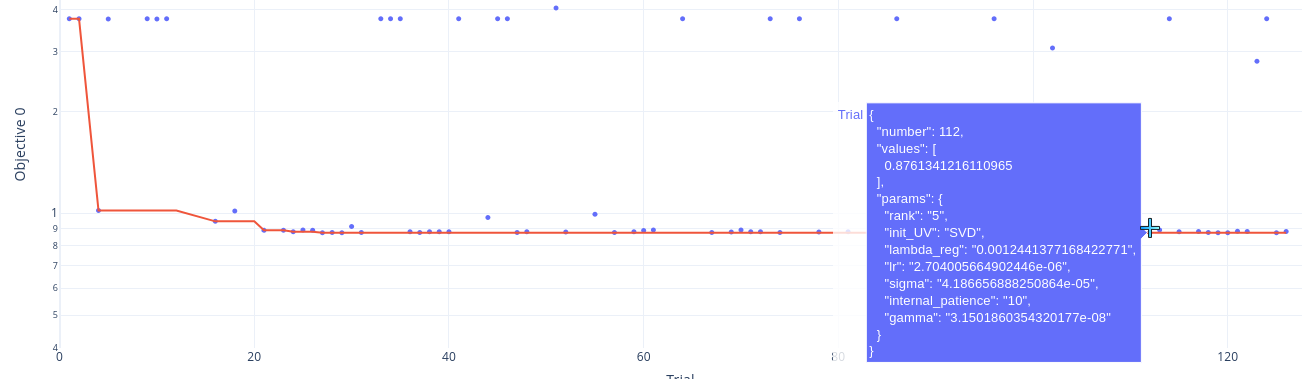

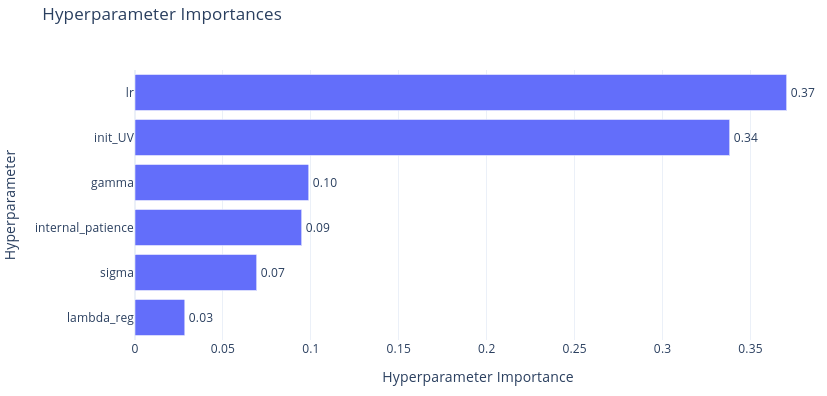

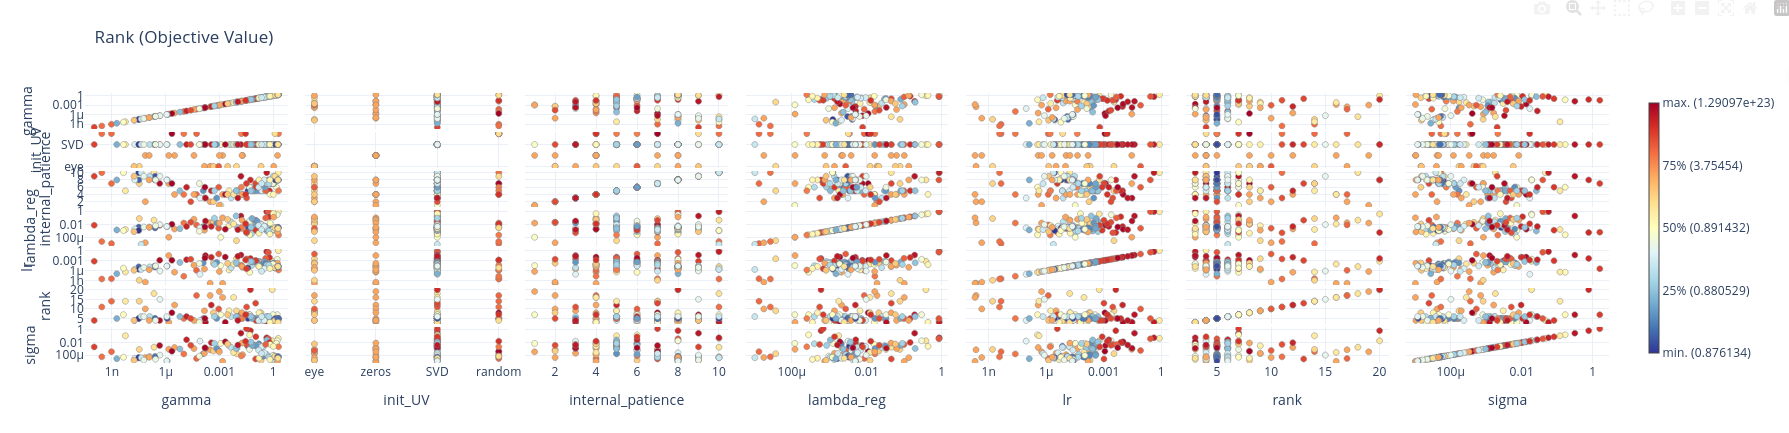

ClearML Task: created new task id=dc47dba798ae4db39b826f5a0952bb46
ClearML results page: https://app.clear.ml/projects/520a519c5b09413f9400a52e9dbf3d61/experiments/dc47dba798ae4db39b826f5a0952bb46/output/log
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


Training:   1%|█▏                                                                                                                         | 1/100 [00:03<05:41,  3.45s/it]

Iteration 1: Training Loss = 0.79938
Validation RMSE: 0.87614


Training:   6%|███████▍                                                                                                                   | 6/100 [00:20<04:46,  3.05s/it]

Iteration 6: Training Loss = 0.79936
Validation RMSE: 0.87615


Training:  11%|█████████████▍                                                                                                            | 11/100 [00:35<04:26,  3.00s/it]

Iteration 11: Training Loss = 0.79936
Validation RMSE: 0.87615


Training:  15%|██████████████████▎                                                                                                       | 15/100 [00:48<04:34,  3.23s/it]

Iteration 16: Training Loss = 0.79936
Validation RMSE: 0.87616
Converged at iteration 16
Training Loss = 0.79936
Validation RMSE: 0.87616


1         4.25981
2         4.14537
3         4.34808
4         4.66031
5         4.33712
           ...   
200037    4.12842
200038    3.59626
200039    3.42978
200040    4.41284
200041    3.47371
Length: 200041, dtype: float64

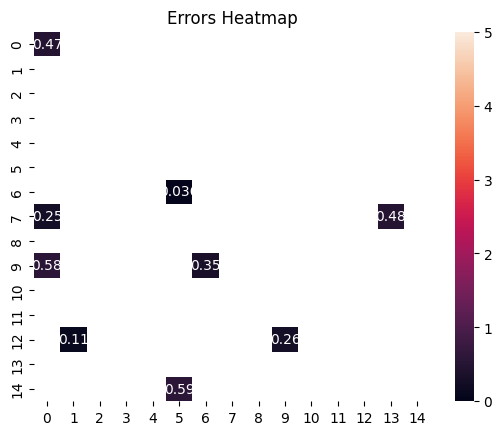

In [40]:
configs = dict(max_iter=100, tol=1e-5, precision=5, seed=42, log_step=5, internal_patience=10,
               init_UV=best_trial_BCGD.params['init_UV'], predicts_path='./BCGD/predicts.csv',
               r=best_trial_BCGD.params['rank'], lambda_reg=best_trial_BCGD.params['lambda_reg'],
               lr=best_trial_BCGD.params['lr'], sigma=best_trial_BCGD.params['sigma'], gamma=best_trial_BCGD.params['gamma'])

kaggle_BCGD = HDDA(X='./inputX.mat', r=configs['r'], patience=1,
                   task_name='kaggle_BCGD', precision=configs['precision'], 
                   debug=False, seed=configs['seed'])
kaggle_BCGD.create_val(0.2)

kaggle_BCGD.init_UV(configs['init_UV'])
kaggle_BCGD.BCGD(max_iter=configs['max_iter'], tol=configs['tol'], patience=configs['internal_patience'],
                 lambda_reg=configs['lambda_reg'], log_step=configs['log_step'],
                 lr=configs['lr'],  sigma=configs['sigma'],  gamma=configs['gamma'])
kaggle_BCGD.show_error_heatmap(15)

os.makedirs('./BCGD/', exist_ok=True)
kaggle_BCGD.test(path='./inputEval.mat', predicts_path=configs['predicts_path'])
np.savetxt("./BCGD/U.csv", kaggle_BCGD.U, delimiter=",")
np.savetxt("./BCGD/V.csv", kaggle_BCGD.V, delimiter=",")

kaggle_BCGD.task.close()
kaggle_BCGD.test_predicts

In [42]:
# Warning: we have only 10 submissions per day, use it carefully!
message = f'Block coordinate gradient descent method with: {kaggle_BCGD.iterations_completed} iterations overall, {kaggle_BCGD.finish_val_loss} rmse on validation, configs: {configs}'
kaggle_BCGD.submit(configs['predicts_path'], message=message)
message

100%|██████████| 2.72M/2.72M [00:01<00:00, 1.59MB/s]


Successfully submitted to Recommendation System Project

"Block coordinate gradient descent method with: 100 iterations overall, 0.8761560782938945 rmse on validation, configs: {'max_iter': 100, 'tol': 1e-05, 'precision': 5, 'seed': 42, 'log_step': 5, 'internal_patience': 10, 'init_UV': 'SVD', 'predicts_path': './BCGD/predicts.csv', 'r': 5, 'lambda_reg': 0.0012441377168422771, 'lr': 2.704005664902446e-06, 'sigma': 4.186656888250864e-05, 'gamma': 3.1501860354320177e-08}"

Here we have 0.8734 rmse on the test set (with 0.87615 rmse on validation set)

# <a id='toc4_'></a>[Update](#toc0_)

The method alternates between updating the latent factor matrices $ \mathbf{U} \in \mathbb{R}^{n \times k} $ and $ \mathbf{V} \in \mathbb{R}^{m \times k} $ to minimize the objective function:
$$
L(\mathbf{U}, \mathbf{V}) = \frac{1}{2} \|\mathbf{X} - \mathbf{U}\mathbf{V}^\top\|_F^2 + \frac{\lambda}{2} (\|\mathbf{U}\|_F^2 + \|\mathbf{V}\|_F^2),
$$
where:
- $ \mathbf{X} \in \mathbb{R}^{n \times m} $ is the observed data matrix,
- $ \|\cdot\|_F $ denotes the Frobenius norm,
- $ \lambda > 0 $ is the regularization coefficient.

Each step involves solving for one variable while keeping the other fixed:
1. Fix $ \mathbf{V} $, update $ \mathbf{U} $ using a gradient descent step.
2. Fix $ \mathbf{U} $, update $ \mathbf{V} $ using a gradient descent step.

The updates use the **Armijo rule** to adaptively choose a step size $ \alpha $ that ensures sufficient decrease in the objective.

---

**1D Armijo Rule**

In a 1D optimization problem, consider minimizing a function $ f(x) $ with gradient descent:
$$
x^{(k+1)} = x^{(k)} - \alpha \nabla f(x^{(k)}),
$$
where $ \alpha > 0 $ is the step size. The Armijo condition states:
$$
f(x^{(k+1)}) \leq f(x^{(k)}) - \gamma \alpha |\nabla f(x^{(k)})|^2,
$$
for some $ \gamma \in (0, 1) $. This ensures the step size $ \alpha $ decreases the objective sufficiently relative to the magnitude of the gradient.

---

**From 1D to Multidimensional Case**

In a multidimensional setting, we extend $ x \in \mathbb{R}^n $ to a vector and generalize the gradient descent update:
$$
\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - \alpha \nabla f(\mathbf{x}^{(k)}),
$$
with the Armijo condition:
$$
f(\mathbf{x}^{(k+1)}) \leq f(\mathbf{x}^{(k)}) - \gamma \alpha \|\nabla f(\mathbf{x}^{(k)})\|_2^2,
$$
where $ \|\nabla f(\mathbf{x})\|_2^2 $ is the squared Euclidean norm of the gradient.

---

**Matrix Case: Armijo Rule for Block Updates**

When optimizing $ L(\mathbf{U}, \mathbf{V}) $, the update for $ \mathbf{U} $ becomes:
$$
\mathbf{U}^{(k+1)} = \mathbf{U}^{(k)} - \alpha \nabla_{\mathbf{U}} L(\mathbf{U}^{(k)}, \mathbf{V}^{(k)}),
$$
where $ \nabla_{\mathbf{U}} L $ is the gradient of the loss with respect to $ \mathbf{U} $. Similarly, for $ \mathbf{V} $:
$$
\mathbf{V}^{(k+1)} = \mathbf{V}^{(k)} - \alpha \nabla_{\mathbf{V}} L(\mathbf{U}^{(k)}, \mathbf{V}^{(k)}).
$$

The Armijo condition for the matrix case is:
$$
L(\mathbf{U}^{(k+1)}, \mathbf{V}) \leq L(\mathbf{U}^{(k)}, \mathbf{V}) - \gamma \alpha \|\nabla_{\mathbf{U}} L(\mathbf{U}^{(k)}, \mathbf{V})\|_F^2,
$$
and similarly for $ \mathbf{V} $:
$$
L(\mathbf{U}, \mathbf{V}^{(k+1)}) \leq L(\mathbf{U}, \mathbf{V}^{(k)}) - \gamma \alpha \|\nabla_{\mathbf{V}} L(\mathbf{U}, \mathbf{V}^{(k)})\|_F^2.
$$

Here:
- $ \|\cdot\|_F^2 $ represents the squared Frobenius norm, summing over all elements of the gradient matrix.

---

**Key Steps in the Armijo Rule Application**

1. **Initialize $ \alpha = \beta^c $**:
   - Start with a step size defined as an initial guess $ \alpha_0 = \beta^c $, where $ c $ is an integer.

2. **Check Armijo Condition**:
   - Evaluate $ L(\mathbf{U} - \alpha \nabla_{\mathbf{U}} L, \mathbf{V}) $.
   - If the condition fails, reduce $ \alpha $ by multiplying it with $ \beta $, i.e., $ \alpha \leftarrow \beta \alpha $.

3. **Repeat Until Satisfied**:
   - Continue reducing $ \alpha $ until the Armijo condition is met or the patience limit is reached.

---

**Advantages of Armijo Rule in BCGD**

- Ensures adaptive step size, avoiding overly large updates.
- Balances convergence speed with numerical stability.
- Naturally extends to matrix factorization problems, preserving the structure of $ \mathbf{U} $ and $ \mathbf{V} $.

In [12]:
@add_to_class(HDDA)
def BCGD_armijo(
    self,
    c: int = 0,
    beta: float = 0.8,
    gamma: float = 0.5,
    max_iter: int = 100,
    log_step: int = 2,
    tol: float = 1e-4,
    patience: int = 10,
    lambda_reg: float = 0.1
) -> np.ndarray:
    """
    Implements Block Coordinate Gradient Descent (BCGD) with an adaptive step size 
    determined by the Armijo rule for optimizing latent matrices in matrix factorization tasks.

    Parameters
    ----------
    c : int, optional
        Initial exponent for scaling the step size (`alpha = beta**c`), default is 0.
    
    beta : float, optional
        Step size reduction factor when the Armijo condition is not satisfied, must be in (0, 1), default is 0.8.
    
    gamma : float, optional
        Parameter controlling the strictness of the Armijo condition. Values should be in [1e-4, 0.5], default is 0.5.
    
    max_iter : int, optional
        Maximum number of iterations for the block coordinate descent, default is 100.
    
    log_step : int, optional
        Frequency of logging metrics during training (in iterations), default is 2.
    
    tol : float, optional
        Tolerance for early stopping based on the change in loss. Default is 1e-4.
    
    patience : int, optional
        Maximum number of attempts to satisfy the Armijo condition or reduce the training loss, default is 10.
    
    lambda_reg : float, optional
        Regularization coefficient for the latent matrices `U` and `V`, default is 0.1.

    Returns
    -------
    np.ndarray
        The final predicted matrix obtained after optimizing the latent matrices `U` and `V`.

    Notes
    -----
    - **Armijo Rule**: The step size is adapted dynamically to ensure sufficient decrease in the loss function. The Armijo condition is:
        ```
        f(x + α * p) <= f(x) + γ * α * ||p.T @ p||_F^2
        ```
        where `f` is the loss function, `x` is the parameter matrix, `p` is the update direction, `α` is the step size, and `γ` is the sufficient decrease parameter.

    - **Block Updates**: Alternates between optimizing two latent matrices (`U` and `V`) by:
        1. Computing the gradient for the current block.
        2. Applying the Armijo rule to find an optimal step size.
        3. Updating the block using the gradient and the step size.

    - **Error Metrics**: Uses RMSE and MSE to track reconstruction error and validate the quality of updates.

    Example
    -------
    ```python
    hdda_instance = HDDA(...)
    hdda_instance.BCGD_armijo(
        beta=0.85,
        gamma=0.4,
        max_iter=200,
        log_step=5,
        tol=1e-5,
        patience=15,
        lambda_reg=0.2
    )
    ```
    """

    train_losses: list[float] = []
    val_losses: list[float] = []
    prev_loss: float = np.inf

    def armijo_rule_(
        idx: int,
        f: Callable[[np.ndarray], float],
        x: np.ndarray,
        p: np.ndarray,
        beta: float = beta,
        gamma: float = gamma,
        c: int = c
    ) -> Tuple[float, int]:
        """
        Determines the step size (`alpha`) using the Armijo rule.
        Armijo Rule for matrix block updates: https://www.epfl.ch/labs/anchp/wp-content/uploads/2018/05/part3-1.pdf

        Parameters
        ----------
        idx : int
            Current iteration index.
        
        f : Callable
            Loss function to evaluate the Armijo condition.
        
        x : np.ndarray
            Current parameter matrix.
        
        p : np.ndarray
            Update direction (e.g., gradient).
        
        beta : float, optional
            Step size reduction factor, default is 0.8.
        
        gamma : float, optional
            Sufficient decrease parameter, default is 0.5.
        
        c : int, optional
            Initial scaling exponent for the step size, default is 0.

        Returns
        -------
        Tuple[float, int]
            The determined step size (`alpha`) and updated scaling exponent (`c`).
        """
        alpha: float = beta**c
        for _ in range(patience):
            if f(x - alpha * p) - f(x) > -gamma * alpha * np.linalg.norm(p.T @ p, ord='fro')**2:
                c += 1
                alpha = beta**c
            else:
                break
        return alpha, c

    def update_block(
        B: np.ndarray,
        fixed_B: np.ndarray,
        WR_f: Callable[[np.ndarray, np.ndarray], np.ndarray],
        grad_f: Callable[[np.ndarray, np.ndarray, np.ndarray], np.ndarray],
        idx: int,
        c: int
    ) -> Tuple[np.ndarray, float, float, int]:
        """
        Updates a block matrix (`U` or `V`) using the Armijo rule.

        Parameters
        ----------
        B : np.ndarray
            Block matrix to update.
        
        fixed_B : np.ndarray
            Fixed block matrix used in calculations.
        
        WR_f : Callable
            Function to compute the error matrix `WR`.
        
        grad_f : Callable
            Function to compute the gradient for the block.
        
        idx : int
            Current iteration index.
        
        c : int
            Initial scaling exponent for step size.

        Returns
        -------
        Tuple[np.ndarray, float, float, int]
            Updated block matrix, final step size, final error, and updated scaling exponent.
        """
        WR = WR_f(B, fixed_B)
        grad_B = grad_f(WR, B, fixed_B)
        loss_f = lambda b: HDDA.mse(WR_f(b, fixed_B))

        alpha, c = armijo_rule_(idx, loss_f, B, grad_B, c=c)
        updated_B = B - alpha * grad_B
        error_1 = HDDA.rmse(WR_f(updated_B, fixed_B))
        return updated_B, alpha, error_1, c

    c_U, c_V = c, c
    for idx in tqdm(range(max_iter), desc="Training"):
        self.U, lr_U, loss_u, c_U = update_block(
            self.U, self.V,
            lambda U, V: self.calc_errors_matrix(U, V),
            lambda WR, U, V: -2 * WR @ V.T + lambda_reg * U,
            idx, c_U
        )
        self.V, lr_V, loss_v, c_V = update_block(
            self.V, self.U,
            lambda V, U: self.calc_errors_matrix(U, V),
            lambda WR, V, U: -(2 * WR.T @ U + lambda_reg * V.T).T,
            idx, c_V
        )
        if hasattr(self, 'logger'):
            self.logger.report_scalar('step_size', 'train_U', lr_U, idx)
            self.logger.report_scalar('loss', 'train_U', loss_u, idx)
            self.logger.report_scalar('step_size', 'train_V', lr_V, idx)
            self.logger.report_scalar('loss', 'train_V', loss_v, idx)

        converged, train_loss, val_loss, prev_loss = self.log_metrics(
            self.U, self.V, idx, log_step, max_iter, prev_loss, tol
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if converged:
            break

    if hasattr(self, "val"):
        self.finish_val_loss = val_losses[-1]

    return self.predict(self.U, self.V)

Seeded everything!


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2654.68it/s]

Iteration 1: Training Loss = 1.3010616817
Iteration 30: Training Loss = 0.0623687531


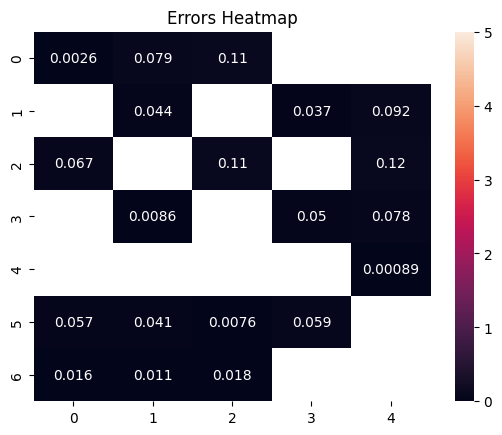

In [13]:
test_BCGD_method = HDDA(X=np.array([
                    [2, 3, 2, np.nan, np.nan],
                    [np.nan, 2, np.nan, 4, 3],
                    [3, np.nan, 3, np.nan, 4],
                    [np.nan, 3, np.nan, 4, 3],
                    [np.nan, np.nan, np.nan, np.nan, 2],
                    [1, 4, 3, 4, np.nan],
                    [5, 3, 2, np.nan, np.nan]]),
                r=2, task_name='test_BCGD', precision=10
    )
test_BCGD_method.init_UV('random')
test_BCGD_method.BCGD_armijo(c=0, beta=0.73, gamma=0.00001, max_iter=30, log_step=50, tol=1e-4, lambda_reg=0.001)
test_BCGD_method.show_error_heatmap(7)

### <a id='toc4_1_1_'></a>[Hyperparameters tuning](#toc0_)

In [ ]:
# Define the objective function for Optuna optimization
def objective(trial: optuna.Trial):
    # Suggest the rank of the matrix factorization (dimensionality of latent factors)
    rank = trial.suggest_int("rank", 4, 10)
    
    # Suggest the initialization method for matrices U and V
    init_UV = trial.suggest_categorical("init_UV", ["random", "eye", "zeros", "SVD"])
    
    # Suggest a regularization parameter for controlling overfitting (lambda regularization)
    lambda_reg = trial.suggest_float("lambda_reg", 1e-5, 1, log=True)
    
    # Suggest the value of the Armijo step size parameter `c`
    c = trial.suggest_int("c", 0, 20)
    
    # Suggest the patience for internal stopping criteria (number of iterations without improvement)
    internal_patience = trial.suggest_int("internal_patience", 1, 10)
    
    # Suggest the value of the Armijo backtracking parameter `gamma`
    gamma = trial.suggest_float("gamma", 1e-3, 0.5, log=True)
    
    # Suggest the value of the step size reduction factor `beta` for the Armijo line search
    beta = trial.suggest_float("beta", 1e-5, 1, log=True)

    # Initialize the HDDA class with the dataset and hyperparameters
    kaggle_BCGD_armj = HDDA(X='./inputX.mat',  # Input data file
                            r=rank,           # Latent rank
                            precision=5,      # Precision level for calculations
                            patience=1,       # General patience for early stopping
                            debug=True,       # Enable debugging information
                            seed=42)          # Random seed for reproducibility
    
    # Split the data into training and validation sets (e.g., 80% train, 20% validation)
    kaggle_BCGD_armj.create_val(0.2)
    
    # Initialize the factorization matrices (U, V) using the chosen method
    kaggle_BCGD_armj.init_UV(init_UV)
    
    # Run the BCGD algorithm with Armijo line search for optimization
    kaggle_BCGD_armj.BCGD_armijo(max_iter=20,       # Maximum number of iterations
                                 tol=1e-4,          # Tolerance for convergence
                                 patience=internal_patience,  # Internal stopping patience
                                 log_step=1,        # Log every `log_step` iterations
                                 c=c,               # Armijo parameter `c`
                                 gamma=gamma,       # Armijo parameter `gamma`
                                 beta=beta,         # Armijo parameter `beta`
                                 lambda_reg=lambda_reg)  # Regularization parameter
    
    # Return the final validation loss to Optuna (objective metric to minimize)
    return kaggle_BCGD_armj.finish_val_loss

# Create an Optuna study for hyperparameter optimization
study = optuna.create_study(storage="sqlite:///db.sqlite3",  # SQLite database for study results
                            study_name="hdda-project-recommendation_systems-BCGD_armj",  # Study name
                            direction="minimize",  # Goal is to minimize the objective
                            load_if_exists=True)  # Reload study if it already exists

# Optimize the objective function with the defined number of trials
study.optimize(objective, n_trials=50, show_progress_bar=True)  # Run 5 trials, show progress bar


[I 2024-11-27 15:29:51,182] Using an existing study with name 'hdda-project-recommendation_systems-BCGD_armj' instead of creating a new one.


  0%|          | 0/50 [00:00<?, ?it/s]

Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!
Iteration 1: Training Loss = 3.74963
Validation RMSE: 3.75321
Iteration 2: Training Loss = 3.74963
Validation RMSE: 3.75321
Iteration 3: Training Loss = 3.74963
Validation RMSE: 3.75321


 ... (more hidden) ...

Iteration 4: Training Loss = 3.74963
Validation RMSE: 3.75321
Converged at iteration 4
Training Loss = 3.74963
Validation RMSE: 3.75321


[I 2024-11-27 15:30:39,971] Trial 15 finished with value: 3.75321425536476 and parameters: {'rank': 7, 'init_UV': 'SVD', 'lambda_reg': 0.39396212016852217, 'c': 16, 'internal_patience': 8, 'gamma': 0.26183825813272565, 'beta': 0.0002810454077734995}. Best is trial 13 with value: 3.75321425536476.
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


 ... (more hidden) ...

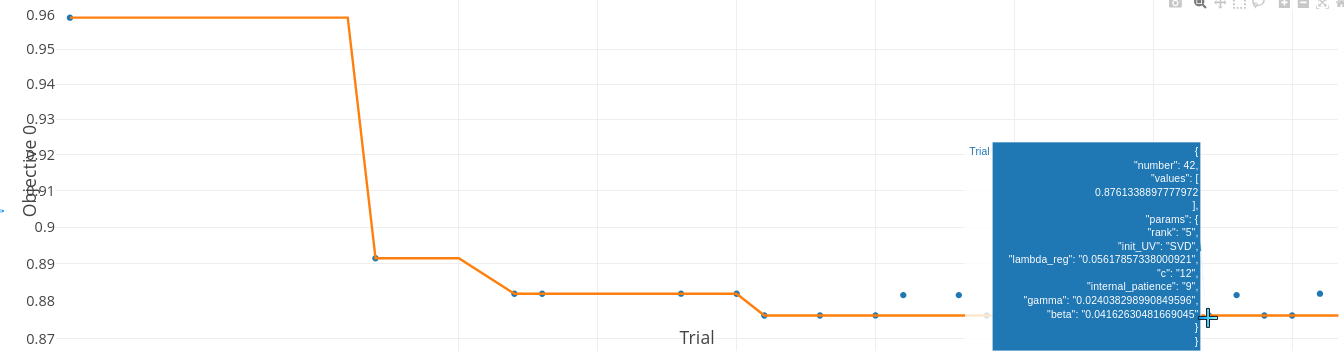

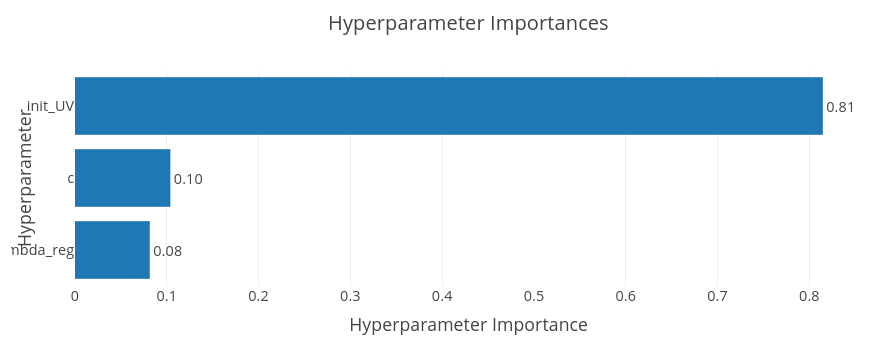

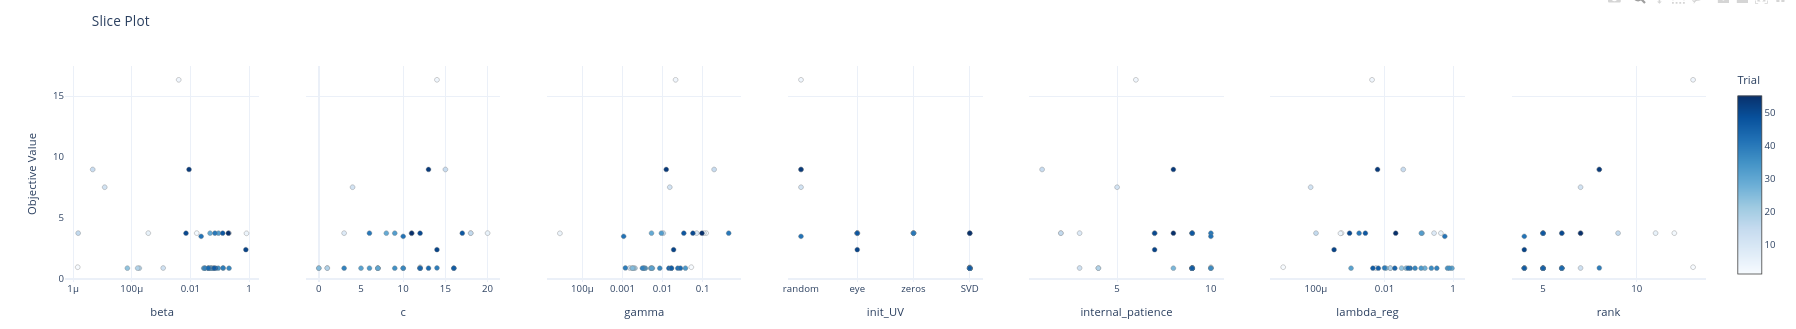

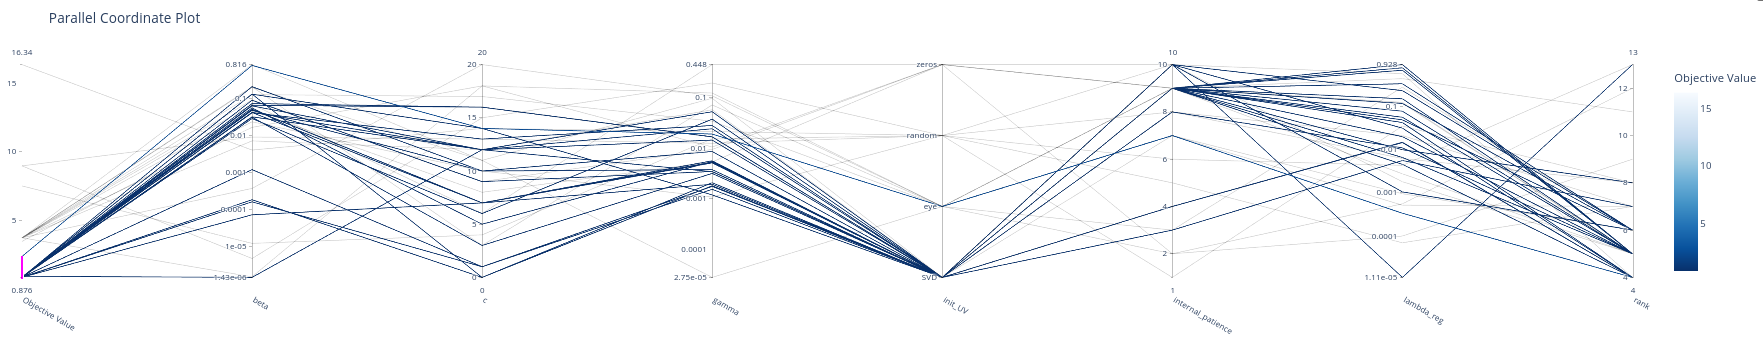

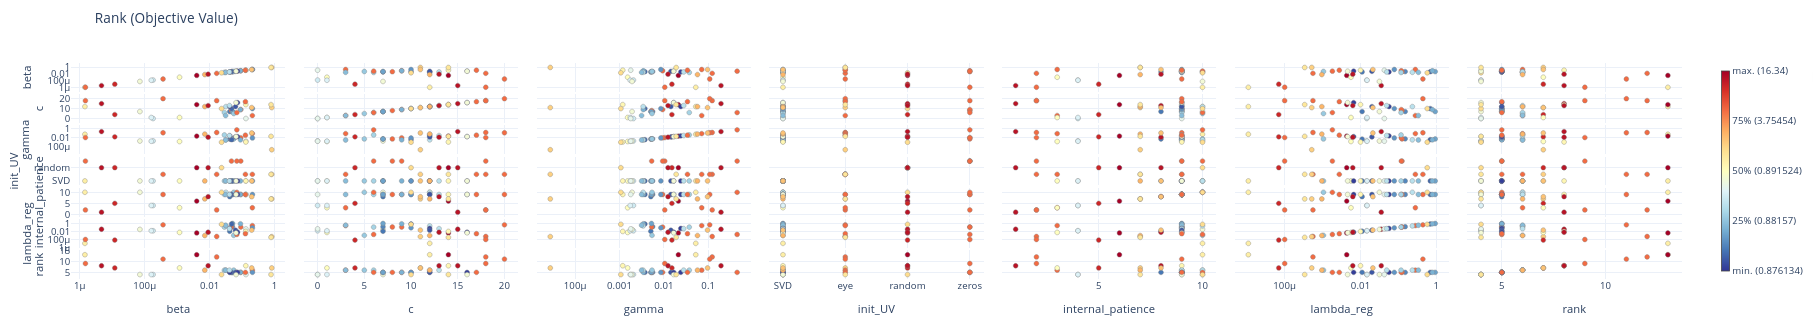

In [16]:
best_trial_BCGD_armj = study.best_trial
configs = dict(max_iter=100, tol=1e-4, precision=5, seed=42, log_step=5, internal_patience=best_trial_BCGD_armj.params['internal_patience'],
               init_UV=best_trial_BCGD_armj.params['init_UV'], predicts_path='./BCGD_armj/predicts.csv',
               r=best_trial_BCGD_armj.params['rank'], lambda_reg=best_trial_BCGD_armj.params['lambda_reg'],
               c=best_trial_BCGD_armj.params['c'], gamma=best_trial_BCGD_armj.params['gamma'], beta=best_trial_BCGD_armj.params['beta'])

kaggle_BCGD_armj = HDDA(X='./inputX.mat', r=configs['r'], patience=2,
                   task_name='kaggle_BCGD_armj', precision=configs['precision'], 
                   debug=False, seed=configs['seed'])
kaggle_BCGD_armj.create_val(0.2)

kaggle_BCGD_armj.init_UV(configs['init_UV'])
kaggle_BCGD_armj.BCGD_armijo(max_iter=configs['max_iter'], tol=configs['tol'], patience=10,
                             lambda_reg=configs['lambda_reg'], log_step=configs['log_step'],
                             c=configs['c'], gamma=configs['gamma'], beta=configs['beta'])
kaggle_BCGD_armj.show_error_heatmap(15)

os.makedirs('./BCGD_armj/', exist_ok=True)
kaggle_BCGD_armj.test(path='./inputEval.mat', predicts_path=configs['predicts_path'])
np.savetxt("./BCGD_armj/U.csv", kaggle_BCGD_armj.U, delimiter=",")
np.savetxt("./BCGD_armj/V.csv", kaggle_BCGD_armj.V, delimiter=",")

kaggle_BCGD_armj.task.close()
kaggle_BCGD_armj.test_predicts

ClearML Task: created new task id=a41b84b3cc4545adbd72b56351bca428
ClearML results page: https://app.clear.ml/projects/520a519c5b09413f9400a52e9dbf3d61/experiments/a41b84b3cc4545adbd72b56351bca428/output/log
Seeded everything!
Train size: 640135	Validation size: 160033
Seeded everything!


 ... (more hidden) ...

Iteration 1: Training Loss = 3.74985
Validation RMSE: 3.75344


 ... (more hidden) ...

Iteration 6: Training Loss = 3.74985
Validation RMSE: 3.75344


 ... (more hidden) ...

Iteration 11: Training Loss = 3.74985
Validation RMSE: 3.75344


 ... (more hidden) ...


KeyboardInterrupt: 

In [52]:
# Warning: we have only 10 submissions per day, use it carefully!
message = f'Block coordinate gradient descent method with armijo rule: {kaggle_BCGD_armj.iterations_completed} iterations overall, {kaggle_BCGD_armj.finish_val_loss} rmse on validation, all configs: {configs}'
kaggle_BCGD_armj.submit(configs['predicts_path'], message=message)
message

100%|██████████| 2.72M/2.72M [00:01<00:00, 1.63MB/s]


Successfully submitted to Recommendation System Project

"Block coordinate gradient descent method with armijo rule: 100 iterations overall, 0.8761400549304317 rmse on validation, all configs: {'max_iter': 100, 'tol': 0.0001, 'precision': 5, 'seed': 42, 'log_step': 5, 'internal_patience': 9, 'init_UV': 'SVD', 'predicts_path': './BCGD_armj/predicts.csv', 'r': 5, 'lambda_reg': 0.05617857338000921, 'c': 12, 'gamma': 0.024038298990849596, 'beta': 0.04162630481669045}"